In [2]:
import pandas as pd
import sqlite3
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import scipy
import pylab
import math
from operator import itemgetter
from itertools import *
from scipy.sparse import csr_matrix
from sklearn.utils.extmath import randomized_svd
import numpy as np 
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
conn=sqlite3.connect('Instacart.db')
c=conn.cursor()

In [3]:
%%time
train_set=pd.read_sql_query('select * from final_train',conn)
train_set.head()

CPU times: user 21.7 s, sys: 1.01 s, total: 22.7 s
Wall time: 25.4 s


,user_id,product_id,reordered,order_id
0,1,196,1.0,1187899.0
1,1,12427,0.0,1187899.0
2,1,14084,0.0,1187899.0
3,1,26088,1.0,1187899.0
4,1,26405,1.0,1187899.0


In [4]:
train_set.reordered.value_counts()

0.0    7645837
1.0     828824
Name: reordered, dtype: int64

# **Featurization**

## ***1. Total number of orders by each user***

In [5]:
query='''select user_id,count(distinct(order_id)) as number_of_orders from orders
where eval_set='prior'
group by user_id
'''
number_of_products_by_user=pd.read_sql_query(query,conn)
number_of_products_by_user.head()

,user_id,number_of_orders
0,1,10
1,2,14
2,3,12
3,4,5
4,5,4


In [6]:
print('Number of users: {}'.format(number_of_products_by_user.user_id.unique().shape[0]))

Number of users: 206209


## ***2. Total number of orders with reordered items by each user***

In [7]:
query='''select user_id,count(distinct(order_id)) as number_of_orders_with_reorders from(select user_id,order_id from prior_user_product_combo
group by order_id
having sum(reordered)>0) tab_1
group by user_id
'''
number_of_orders_with_reorders_per_user=pd.read_sql_query(query,conn)

In [8]:
number_of_orders_with_reorders_per_user.head()

,user_id,number_of_orders_with_reorders
0,1,9
1,2,12
2,3,11
3,4,1
4,5,3


In [9]:
print('Number of users with orders containing reordered products: {}'.format(number_of_orders_with_reorders_per_user.user_id.unique().shape[0]))

Number of users with orders containing reordered products: 203164


In [60]:
# We can abserve that around 3k users have orders without any reordered products

In [38]:
# Merging feature 1 and 2 with train data
train_num_of_order_reordered=pd.merge(train_set,number_of_products_by_user,on='user_id',how='left')
train_num_of_order_reordered=pd.merge(train_num_of_order_reordered,number_of_orders_with_reorders_per_user,on='user_id',how='left')

In [39]:
train_num_of_order_reordered[train_num_of_order_reordered.isnull().any(axis=1)]

,user_id,product_id,reordered,order_id,number_of_orders,number_of_orders_with_reorders
11333,286,4528,0.0,3529.0,3,NaN
11334,286,4615,0.0,3529.0,3,NaN
11335,286,32819,0.0,3529.0,3,NaN
11336,286,42240,0.0,3529.0,3,NaN
11337,286,43642,0.0,3529.0,3,NaN
...,...,...,...,...,...,...
8471658,206133,43986,0.0,2104667.0,4,NaN
8471659,206133,49141,0.0,2104667.0,4,NaN
8471660,206133,49615,0.0,2104667.0,4,NaN
8471661,206133,21709,0.0,2104667.0,4,NaN


*These null values of number_of_orders_with_reorders are for users with no orders with reordered items which should be logically filled with 0.*

In [ ]:
train_num_of_order_reordered.fillna(0,inplace=True)

## ***3. User reorder ratio by orders***

   ### User reorder ratio by orders=Number of orders by user with reorders/(Total number of orders by user-1)
   
   ### i.e, feature-3 = feature-2 / featue-1

In [40]:
train_num_of_order_reordered['user_reorder_ratio_by_orders']=train_num_of_order_reordered.number_of_orders_with_reorders/(train_num_of_order_reordered.number_of_orders-1)
# subtracted by 1 in denominator because number_of_orders is along with first order which does not have no reordered products
train_num_of_order_reordered.head()

,user_id,product_id,reordered,order_id,number_of_orders,number_of_orders_with_reorders,user_reorder_ratio_by_orders
0,1,196,1.0,1187899.0,10,9.0,1.0
1,1,12427,0.0,1187899.0,10,9.0,1.0
2,1,14084,0.0,1187899.0,10,9.0,1.0
3,1,26088,1.0,1187899.0,10,9.0,1.0
4,1,26405,1.0,1187899.0,10,9.0,1.0


In [52]:
train_num_of_order_reordered.user_reorder_ratio_by_orders.describe()

count    8.474661e+06
mean     9.369255e-01
std      1.313601e-01
min      0.000000e+00
25%      9.333333e-01
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+00
Name: user_reorder_ratio_by_orders, dtype: float64

In [53]:
user_reorder_ratio=train_num_of_order_reordered.user_reorder_ratio_by_orders
for percentile in [1,5,10,15]:
    print('{} percentile: {}'.format(percentile,np.percentile(user_reorder_ratio,percentile)))

1 percentile: 0.3333333333333333
5 percentile: 0.6666666666666666
10 percentile: 0.8
15 percentile: 0.8666666666666667


Text(0.5, 0.98, 'Plot-1: PDF of user reorder ratio by orders')

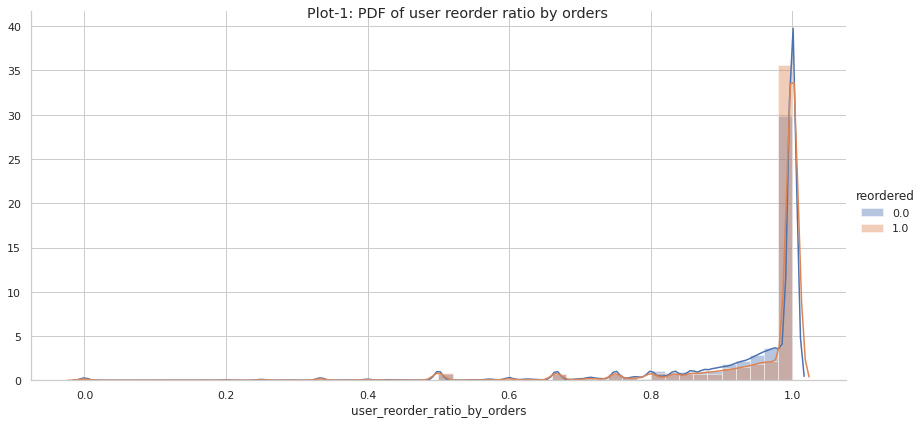

In [51]:
sns.FacetGrid(train_num_of_order_reordered,hue='reordered',height=6,aspect=2).map(sns.distplot,'user_reorder_ratio_by_orders').add_legend().fig.suptitle('Plot-1: PDF of user reorder ratio by orders')

### Plot-1:
* *This is Probability Density Function(Univariate) of User reorder ratio by orders*

 **User reorder ratio by orders=Number of orders by user with reorders/(Total number of orders by user-1)**
 
 
* *This feature is extracted with a assumption that users with high percentage of orders with repurchased products tend to show same behaviour in next orders too but in EDA we observed that there are very less number of orders without reordered products and it also reflected here in this plot as more than 90% of users have user_reorder_ratio_by_orders>0.8.*


* *The feature did not classify data but considering the high class imbalance we can observe peak of reordered=1 at higher user_reorder_ratio_by_orders*

### Joining for storing in DB

In [10]:
user_based_features_set_1=pd.merge(number_of_products_by_user,number_of_orders_with_reorders_per_user,on='user_id',how='outer')

In [11]:
user_based_features_set_1[user_based_features_set_1.isnull().any(axis=1)]

,user_id,number_of_orders,number_of_orders_with_reorders
285,286,3,NaN
307,308,3,NaN
394,395,3,NaN
411,412,4,NaN
512,513,3,NaN
...,...,...,...
205808,205809,3,NaN
205841,205842,3,NaN
205893,205894,3,NaN
206096,206097,5,NaN


In [12]:
user_based_features_set_1.fillna(0,inplace=True)
user_based_features_set_1['user_reorder_ratio_by_orders']=user_based_features_set_1.number_of_orders_with_reorders/(user_based_features_set_1.number_of_orders-1)
user_based_features_set_1.head()

,user_id,number_of_orders,number_of_orders_with_reorders,user_reorder_ratio_by_orders
0,1,10,9.0,1.000000
1,2,14,12.0,0.923077
2,3,12,11.0,1.000000
3,4,5,1.0,0.250000
4,5,4,3.0,1.000000


## ***4. Number of unique products by an user***

In [17]:
query='''select user_id,count(distinct(product_id)) as number_of_unique_products from prior_user_product_combo
group by user_id
'''
number_of_unique_products_by_user=pd.read_sql_query(query,conn)
number_of_unique_products_by_user.head()

,user_id,number_of_unique_products
0,1,18
1,2,102
2,3,33
3,4,17
4,5,23


## ***5. Number of unique products which were reordered by user***

In [18]:
query='''select user_id,count(distinct(product_id)) as number_of_unique_reordered_products from prior_user_product_combo
where reordered=1
group by user_id
'''
number_of_unique_reordered_products_by_user=pd.read_sql_query(query,conn)
number_of_unique_reordered_products_by_user.head()

,user_id,number_of_unique_reordered_products
0,1,10
1,2,37
2,3,19
3,4,1
4,5,8


In [69]:
# Merging feature-4 and 5 with train data
train_unique_ordered_reordered_products_per_user=pd.merge(train_set,number_of_unique_products_by_user,on='user_id',how='left')
train_unique_ordered_reordered_products_per_user=pd.merge(train_unique_ordered_reordered_products_per_user,number_of_unique_reordered_products_by_user,on='user_id',how='left')

In [70]:
train_unique_ordered_reordered_products_per_user[train_unique_ordered_reordered_products_per_user.isnull().any(axis=1)]

,user_id,product_id,reordered,order_id,number_of_unique_products,number_of_unique_reordered_products
11333,286,4528,0.0,3529.0,26,NaN
11334,286,4615,0.0,3529.0,26,NaN
11335,286,32819,0.0,3529.0,26,NaN
11336,286,42240,0.0,3529.0,26,NaN
11337,286,43642,0.0,3529.0,26,NaN
...,...,...,...,...,...,...
8471658,206133,43986,0.0,2104667.0,21,NaN
8471659,206133,49141,0.0,2104667.0,21,NaN
8471660,206133,49615,0.0,2104667.0,21,NaN
8471661,206133,21709,0.0,2104667.0,21,NaN


*These null values of number_of_unique_reordered_products are for users with no products reordered. Logically number_of_unique_reordered_products should be filled with zero here.*

In [71]:
train_unique_ordered_reordered_products_per_user.fillna(0,inplace=True)

## ***6. Unique products reordered ratio by user***

   #### Unique products reorder ratio=No. of unique products which are reordered by user / No. of unique products ordered by user
   
   ### i.e., feature-6 = feature-5/feature-4

In [75]:
train_unique_ordered_reordered_products_per_user['unique_products_reordered_ratio']=train_unique_ordered_reordered_products_per_user.number_of_unique_reordered_products/train_unique_ordered_reordered_products_per_user.number_of_unique_products
train_unique_ordered_reordered_products_per_user.head()

,user_id,product_id,reordered,order_id,number_of_unique_products,number_of_unique_reordered_products,unique_products_reordered_ratio
0,1,196,1.0,1187899.0,18,10.0,0.555556
1,1,12427,0.0,1187899.0,18,10.0,0.555556
2,1,14084,0.0,1187899.0,18,10.0,0.555556
3,1,26088,1.0,1187899.0,18,10.0,0.555556
4,1,26405,1.0,1187899.0,18,10.0,0.555556


In [76]:
train_unique_ordered_reordered_products_per_user.unique_products_reordered_ratio.describe()

count    8.474661e+06
mean     4.001505e-01
std      1.507938e-01
min      0.000000e+00
25%      2.979798e-01
50%      4.060150e-01
75%      5.056818e-01
max      1.000000e+00
Name: unique_products_reordered_ratio, dtype: float64

Text(0.5, 0.98, 'Plot-2: PDF of unique products reordered ratio by user')

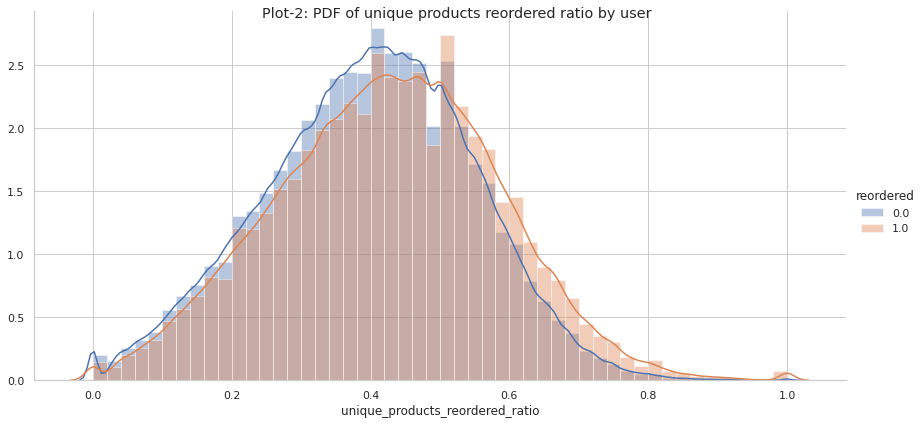

In [74]:
sns.FacetGrid(train_unique_ordered_reordered_products_per_user,hue='reordered',height=6,aspect=2).map(sns.distplot,'unique_products_reordered_ratio').add_legend().fig.suptitle('Plot-2: PDF of unique products reordered ratio by user')

### Plot-2:
* *This is Probability Density Function(Univariate) of unique products reordered ratio by user*

 **Unique products reorder ratio=No. of unique products which are reordered by user / No. of unique products ordered by user**
 
 
* *This feature is extracted with an assumption that the users who have the behaviour of ordering same products in their orders over time can also order same items again.*


* *This did not significantly classify data but we can clearly observe that reorders are more for users with higher Unique products reorder ratio which is my assumption*

### Joining for storing in DB

In [19]:
user_based_features_set_2=pd.merge(number_of_unique_products_by_user,number_of_unique_reordered_products_by_user,on='user_id',how='outer')

In [20]:
user_based_features_set_2[user_based_features_set_2.isnull().any(axis=1)]

,user_id,number_of_unique_products,number_of_unique_reordered_products
285,286,26,NaN
307,308,11,NaN
394,395,18,NaN
411,412,37,NaN
512,513,8,NaN
...,...,...,...
205808,205809,8,NaN
205841,205842,9,NaN
205893,205894,9,NaN
206096,206097,26,NaN


In [21]:
user_based_features_set_2.fillna(0,inplace=True)
user_based_features_set_2['unique_products_reordered_ratio']=user_based_features_set_2.number_of_unique_reordered_products/user_based_features_set_2.number_of_unique_products
user_based_features_set_2.head()

,user_id,number_of_unique_products,number_of_unique_reordered_products,unique_products_reordered_ratio
0,1,18,10.0,0.555556
1,2,102,37.0,0.362745
2,3,33,19.0,0.575758
3,4,17,1.0,0.058824
4,5,23,8.0,0.347826


## ***7. Average(mean), median of gap(days_since_prior_order) between orders per user.*** 

In [25]:
query='''select user_id,days_since_prior_order from orders
where eval_set='prior' and order_number>1
'''
orders=pd.read_sql_query(query,conn)

In [26]:
def mean_of_gap(series):
    # calculate and return mean of series
    return series.mean()

In [27]:
def median_of_gap(series):
    # calculate and return median of series
    return np.median(series)

In [28]:
def std_of_gap(series):
    # calculate and return standard deviation of series
    return np.std(series)

In [29]:
grouped=orders.groupby('user_id').agg({'days_since_prior_order':[mean_of_gap,median_of_gap,std_of_gap]}).reset_index()
# I wrote explicit aggregate function as SQLite3 did not support median and standard deviation aggregate functions

mean_median_std_gaps=pd.DataFrame(grouped.values,columns=['user_id','mean_days_since_prior_order','median_days_since_prior_order','stdev_days_since_prior_order'])

In [30]:
mean_median_std_gaps[mean_median_std_gaps.isnull().any(axis=1)]

,user_id,mean_days_since_prior_order,median_days_since_prior_order,stdev_days_since_prior_order


In [87]:
# Merging features-6 with train set
train_mean_median_std_gap=pd.merge(train_set,mean_median_std_gaps,on='user_id',how='left')
train_mean_median_std_gap.head()

,user_id,product_id,reordered,order_id,mean_days_since_prior_order,median_days_since_prior_order,stdev_days_since_prior_order
0,1,196,1.0,1187899.0,19.555556,20.0,8.858281
1,1,12427,0.0,1187899.0,19.555556,20.0,8.858281
2,1,14084,0.0,1187899.0,19.555556,20.0,8.858281
3,1,26088,1.0,1187899.0,19.555556,20.0,8.858281
4,1,26405,1.0,1187899.0,19.555556,20.0,8.858281


In [88]:
train_mean_median_std_gap[train_mean_median_std_gap.isnull().any(axis=1)]

,user_id,product_id,reordered,order_id,mean_days_since_prior_order,median_days_since_prior_order,stdev_days_since_prior_order


Text(0.5, 0.98, 'Plot-3.1: PDF of mean gap between orders by user')

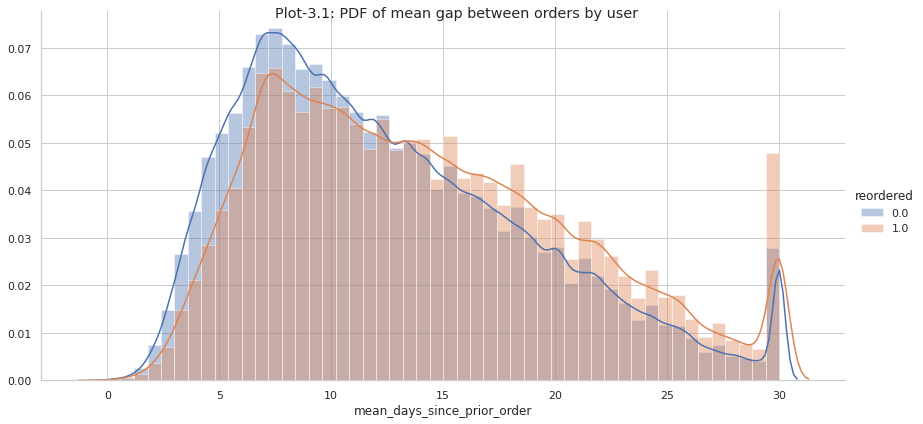

In [89]:
sns.FacetGrid(train_mean_median_std_gap,hue='reordered',height=6,aspect=2).map(sns.distplot,'mean_days_since_prior_order').add_legend().fig.suptitle('Plot-3.1: PDF of mean gap between orders by user')

Text(0.5, 0.98, 'Plot-3.2: PDF of median gap between orders by user')

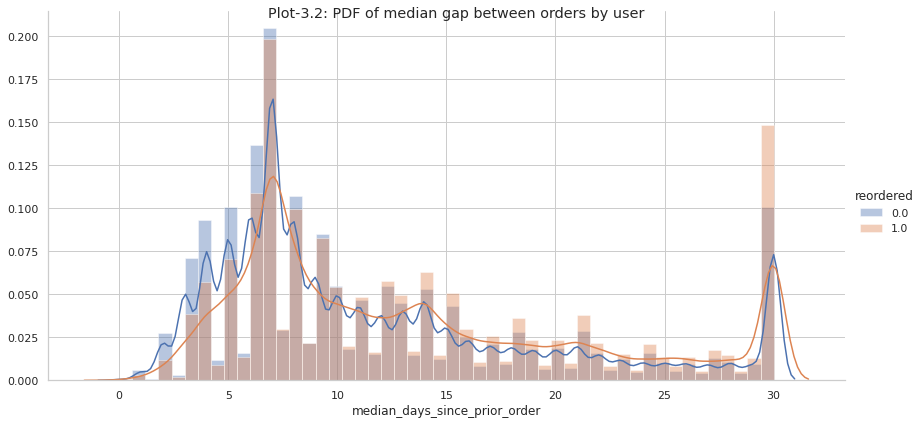

In [90]:
sns.FacetGrid(train_mean_median_std_gap,hue='reordered',height=6,aspect=2).map(sns.distplot,'median_days_since_prior_order').add_legend().fig.suptitle('Plot-3.2: PDF of median gap between orders by user')

Text(0.5, 0.98, 'Plot-3.3: PDF of standard deviation of gap between orders by user')

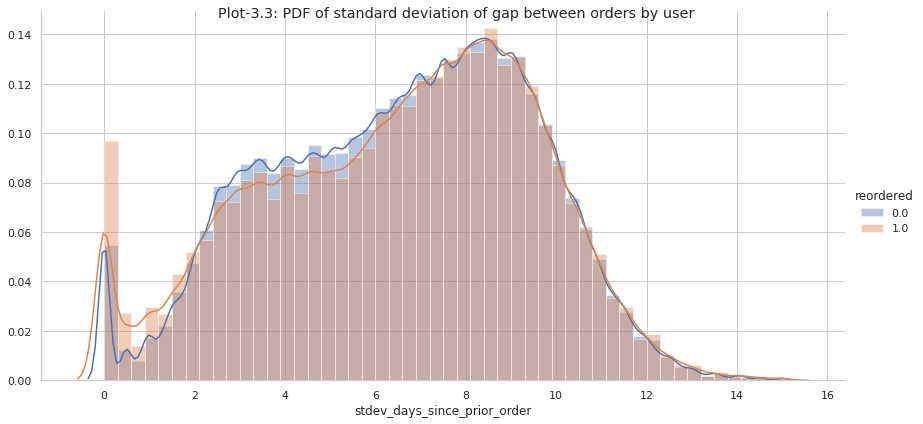

In [91]:
sns.FacetGrid(train_mean_median_std_gap,hue='reordered',height=6,aspect=2).map(sns.distplot,'stdev_days_since_prior_order').add_legend().fig.suptitle('Plot-3.3: PDF of standard deviation of gap between orders by user')

### Plot- 3.1,3.2,3.3

* *These features on gaps(days_since_prior_order) between orders by an user is fetched because in EDA we can observe(plot- 9,10,11) that days_since_prior is more for orders with no reordered products.*


* *None of the plots 3.1,3.2,3.3 could classify the data but in plot 3.1(mean of gaps) we can observe that it's bit higher for reordered products.*


* *These features may be used to predict None orders(orders without reordered products) as per EDA.*

### Storing user related features in Database

In [31]:
user_features_set_1=pd.merge(user_based_features_set_1,user_based_features_set_2,on='user_id',how='outer')
user_features_set_1=pd.merge(user_features_set_1,mean_median_std_gaps,on='user_id',how='outer')

In [32]:
user_features_set_1[user_features_set_1.isnull().any(axis=1)]

,user_id,number_of_orders,number_of_orders_with_reorders,user_reorder_ratio_by_orders,number_of_unique_products,number_of_unique_reordered_products,unique_products_reordered_ratio,mean_days_since_prior_order,median_days_since_prior_order,stdev_days_since_prior_order


In [33]:
user_features_set_1.shape

(206209, 10)

In [34]:
print('Number of users: {}'.format(user_features_set_1.user_id.unique().shape[0]))

Number of users: 206209


In [35]:
user_features_set_1.head()

,user_id,number_of_orders,number_of_orders_with_reorders,user_reorder_ratio_by_orders,number_of_unique_products,number_of_unique_reordered_products,unique_products_reordered_ratio,mean_days_since_prior_order,median_days_since_prior_order,stdev_days_since_prior_order
0,1,10,9.0,1.000000,18,10.0,0.555556,19.555556,20.0,8.858281
1,2,14,12.0,0.923077,102,37.0,0.362745,15.230769,13.0,9.479970
2,3,12,11.0,1.000000,33,19.0,0.575758,12.090909,11.0,5.124887
3,4,5,1.0,0.250000,17,1.0,0.058824,13.750000,17.0,8.227241
4,5,4,3.0,1.000000,23,8.0,0.347826,13.333333,11.0,4.027682


In [37]:
c.execute('create table user_features_set_1(user_id int, number_of_orders int, number_of_orders_with_reorders int, user_reorder_ratio_by_orders decimal, number_of_unique_products int, number_of_unique_reordered_products int, unique_products_reordered_ratio decimal, mean_days_since_prior_order decimal, median_days_since_prior_order decimal, stdev_days_since_prior_order decimal)')
user_features_set_1.to_sql('user_features_set_1', conn, if_exists='replace', index = False)

## ***8. How many times user purchased product in last 5 orders?***

In [44]:
%%time
query='''select tab_1.order_id,tab_1.user_id,tab_1.product_id,tab_1.add_to_cart_order,tab_2.order_number,tab_2.order_day_of_user,tab_1.reordered from prior_user_product_combo tab_1
join (select order_id,order_number,order_day_of_user from orders_refined where eval_set='prior') tab_2 on (tab_1.order_id=tab_2.order_id)
join 
(select user_id,
case
when (max(order_number)-4)>0 then (max(order_number)-4)
else 1
end as fifth_recent_order_number from orders
where eval_set='prior'
group by user_id) tab_3 on (tab_1.user_id=tab_3.user_id and tab_2.order_number>=tab_3.fifth_recent_order_number)
'''
user_product_last5_orders=pd.read_sql_query(query,conn)

CPU times: user 2min 57s, sys: 36.1 s, total: 3min 33s
Wall time: 3min 38s


In [45]:
user_product_last5_orders[user_product_last5_orders.user_id==1]

,order_id,user_id,product_id,add_to_cart_order,order_number,order_day_of_user,reordered
0,3367565,1,196,1,6,113.0,1
1,3367565,1,10258,3,6,113.0,1
2,3367565,1,12427,2,6,113.0,1
3,3367565,1,25133,4,6,113.0,1
4,550135,1,196,1,7,133.0,1
5,550135,1,10258,2,7,133.0,1
6,550135,1,12427,3,7,133.0,1
7,550135,1,13032,5,7,133.0,1
8,550135,1,25133,4,7,133.0,1
9,3108588,1,196,2,8,147.0,1


In [46]:
# How many times an user purchased product in last 5 orders
user_product_count_last5=user_product_last5_orders[['user_id','product_id','reordered']].groupby(['user_id','product_id']).count().reset_index()
user_product_count_last5.rename(columns={'reordered':'u_p_count_L5'},inplace=True)
user_product_count_last5.head()

,user_id,product_id,u_p_count_L5
0,1,196,5
1,1,10258,5
2,1,12427,5
3,1,13032,2
4,1,25133,5


In [47]:
# You can check the working of query and aggregation by comparing the listing of user_id=1 here and above
user_product_count_last5[user_product_count_last5.user_id==1]

,user_id,product_id,u_p_count_L5
0,1,196,5
1,1,10258,5
2,1,12427,5
3,1,13032,2
4,1,25133,5
5,1,35951,1
6,1,38928,1
7,1,39657,1
8,1,46149,3
9,1,49235,2


In [48]:
# Merging with train set
train_user_product_count_last5=pd.merge(train_set,user_product_count_last5,on=['user_id','product_id'],how='left')

In [49]:
train_user_product_count_last5[train_user_product_count_last5.isnull().any(axis=1)]

,user_id,product_id,reordered,order_id,u_p_count_L5
2,1,14084,0.0,1187899.0,NaN
3,1,26088,1.0,1187899.0,NaN
4,1,26405,1.0,1187899.0,NaN
7,1,13176,0.0,1187899.0,NaN
9,1,30450,0.0,1187899.0,NaN
...,...,...,...,...,...
8474636,206209,12376,0.0,272231.0,NaN
8474637,206209,14870,0.0,272231.0,NaN
8474638,206209,16066,0.0,272231.0,NaN
8474639,206209,17500,0.0,272231.0,NaN


In [91]:
# These null values are for products which were not ordered by user in his/her recent 5 orders and should be replaced by 0.
train_user_product_count_last5.fillna(0,inplace=True)

In [92]:
train_user_product_count_last5.head()

,user_id,product_id,reordered,order_id,u_p_count_L5
0,1,196,1.0,1187899.0,5.0
1,1,12427,0.0,1187899.0,5.0
2,1,14084,0.0,1187899.0,0.0
3,1,26088,1.0,1187899.0,0.0
4,1,26405,1.0,1187899.0,0.0


Text(0.5, 0.98, 'Plot-4: PDF of number of times product ordered by user in 5 recent orders')

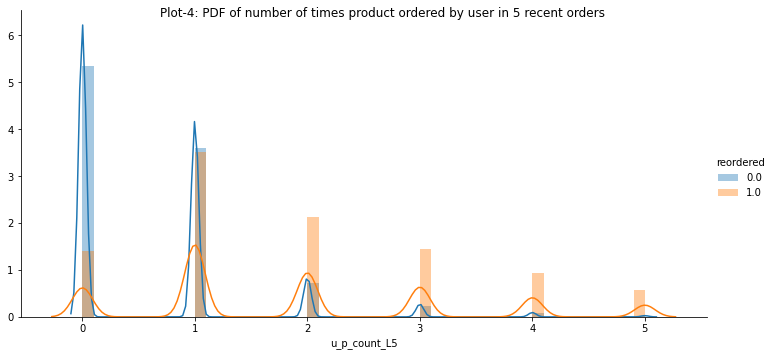

In [96]:
# Histogram should be the ideal plot to show as variable is discrete but PDF is much clearly visible. So I went for PDF
sns.FacetGrid(train_user_product_count_last5,hue='reordered',height=5,aspect=2).map(sns.distplot,'u_p_count_L5').add_legend().fig.suptitle('Plot-4: PDF of number of times product ordered by user in 5 recent orders')

### Plot-4:
* *This is the PDF of How many times an user ordered particular product in their last 5 orders.*
* *This feature is most important in most of the reference works that I have gone through.*
* *Histogram is ideal plot as variable is discrete but I plotted PDF as it is clearly visible than Histogram when I tried.*
* *We can clearly observe that most of the products with 0 order count in last 5 orders were not reordered and we can also clearly observe that the products with order count greater than 2 were most reordered.*
* *This feature can classify data to large extent even with high class imbalance.*

## ***9. Mean, Median,Maximum and Standard Deviation of gaps(days between orders) last 5 orders***

In [50]:
def maximum_gap(series): 
    # This function returns maximum of gaps between an user ordering a product
    # For example an user ordered a product on day 1,5,9,17 than max(gaps)=8 is gap between 9th and 17th day.
    try:
        return np.diff(series).max()
    except ValueError:
        # Value error arises when user ordered product for only 1 item in last 5 orders.
        # np.diff([1]).max() raises ValueError as np.diff([1]) return empty array
        # returning any positive number or 0 in this case is not logically correct.
        # so returing -1 specifies that product is ordered only once and there no scope to compare for maximum gap.
        return -1

In [51]:
def mean_gap(series): 
    # This function returns mean of gaps between an user ordering a product
    mean_gap=np.diff(series).mean()
    if math.isnan(mean_gap):
        # Unlike ValueError in maximum_gap, np.diff([1]).mean() return Nan
        return -1
    else:
        return mean_gap 

In [52]:
def median_gap(series): 
    # This function returns median of gaps between an user ordering a product
    median_gap=np.median(np.diff(series))
    if math.isnan(median_gap):
        # Unlike ValueError in maximum_gap, np.median(np.diff([1])) return Nan
        return -1
    else:
        return median_gap 

In [53]:
def std_gap(series):
    # This function returns Standard Deviarion of gaps between an user ordering a product
    std_gap=np.diff(series).std()
    if math.isnan(std_gap):
        # Unlike ValueError in maximum_gap, np.diff([1]).std() return Nan
        return -1
    else:
        return std_gap 

In [54]:
%%time
mean_median_max_std_gap_L5=pd.DataFrame(user_product_last5_orders[['user_id','product_id','order_day_of_user']].groupby(['user_id','product_id']).agg({'order_day_of_user':[maximum_gap,mean_gap,median_gap,std_gap]}).reset_index().values,columns=['user_id','product_id','max_gap_L5','mean_gap_L5','median_gap_L5','std_gap_L5'])
mean_median_max_std_gap_L5.head()

CPU times: user 23min 26s, sys: 5.53 s, total: 23min 32s
Wall time: 23min 28s


,user_id,product_id,max_gap_L5,mean_gap_L5,median_gap_L5,std_gap_L5
0,1.0,196.0,30.0,16.0,17.0,10.86278
1,1.0,10258.0,30.0,16.0,17.0,10.86278
2,1.0,12427.0,30.0,16.0,17.0,10.86278
3,1.0,13032.0,44.0,44.0,44.0,0.00000
4,1.0,25133.0,30.0,16.0,17.0,10.86278


In [39]:
# m3- mean, median, max
train_m3_std=pd.merge(train_set,mean_median_max_std_gap_L5,on=['user_id','product_id'],how='left')

In [40]:
train_m3_std[train_m3_std.isnull().any(axis=1)]

,user_id,product_id,reordered,order_id,max_gap_L5,mean_gap_L5,median_gap_L5,std_gap_L5
2,1,14084,0.0,1187899.0,NaN,NaN,NaN,NaN
3,1,26088,1.0,1187899.0,NaN,NaN,NaN,NaN
4,1,26405,1.0,1187899.0,NaN,NaN,NaN,NaN
7,1,13176,0.0,1187899.0,NaN,NaN,NaN,NaN
9,1,30450,0.0,1187899.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
8474636,206209,12376,0.0,272231.0,NaN,NaN,NaN,NaN
8474637,206209,14870,0.0,272231.0,NaN,NaN,NaN,NaN
8474638,206209,16066,0.0,272231.0,NaN,NaN,NaN,NaN
8474639,206209,17500,0.0,272231.0,NaN,NaN,NaN,NaN


In [41]:
# These nulls are for products which were not otdered by user in recent 5 orders. filling with 0 is logically in correct.
# for example mean_gap=0 mean that all orders were made on same day.
# So I am explicitily specifying this case by filling with -1.
train_m3_std.fillna(-1,inplace=True)

In [42]:
train_m3_std.head()

,user_id,product_id,reordered,order_id,max_gap_L5,mean_gap_L5,median_gap_L5,std_gap_L5
0,1,196,1.0,1187899.0,30.0,16.0,17.0,10.86278
1,1,12427,0.0,1187899.0,30.0,16.0,17.0,10.86278
2,1,14084,0.0,1187899.0,-1.0,-1.0,-1.0,-1.00000
3,1,26088,1.0,1187899.0,-1.0,-1.0,-1.0,-1.00000
4,1,26405,1.0,1187899.0,-1.0,-1.0,-1.0,-1.00000


Text(0.5, 0.98, 'Plot-5.1: PDF of maximum gap of user ordered particular product in recent 5 orders')

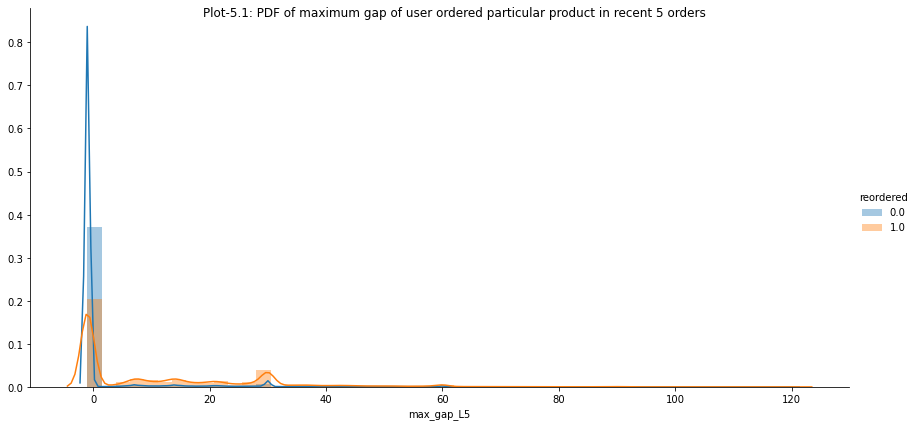

In [130]:
sns.FacetGrid(train_m3_std,hue='reordered',height=6,aspect=2).map(sns.distplot,'max_gap_L5').add_legend().fig.suptitle('Plot-5.1: PDF of maximum gap of user ordered particular product in recent 5 orders')

Text(0.5, 0.98, 'Plot-5.2: PDF of mean of gaps between user ordered particular product in recent 5 orders')

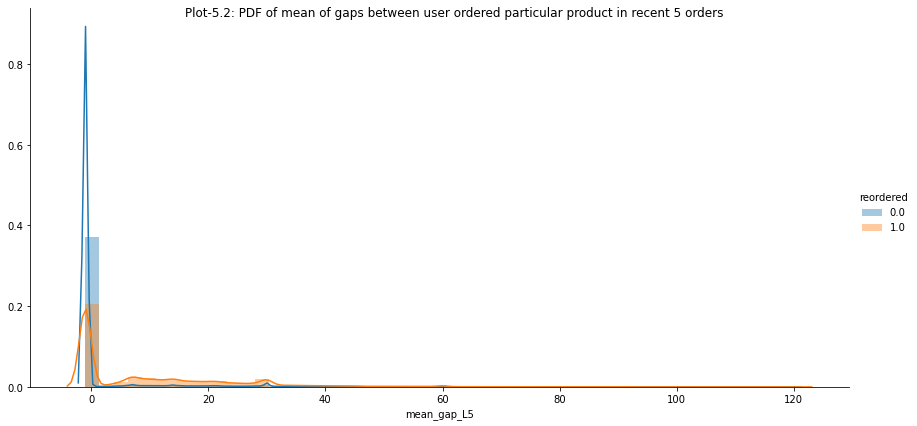

In [131]:
sns.FacetGrid(train_m3_std,hue='reordered',height=6,aspect=2).map(sns.distplot,'mean_gap_L5').add_legend().fig.suptitle('Plot-5.2: PDF of mean of gaps between user ordered particular product in recent 5 orders')

Text(0.5, 0.98, 'Plot-5.3: PDF of median of gaps between user ordered particular product in recent 5 orders')

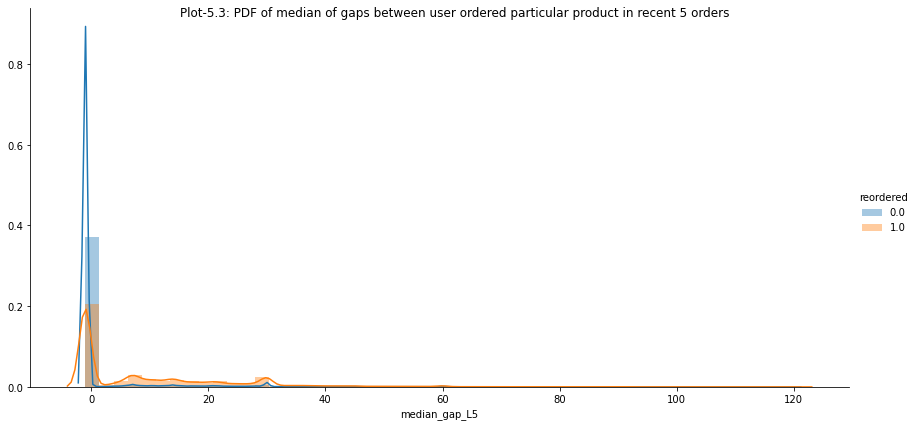

In [132]:
sns.FacetGrid(train_m3_std,hue='reordered',height=6,aspect=2).map(sns.distplot,'median_gap_L5').add_legend().fig.suptitle('Plot-5.3: PDF of median of gaps between user ordered particular product in recent 5 orders')

Text(0.5, 0.98, 'Plot-5.4: PDF of Standard Deviation of gaps between user ordered particular product in recent 5 orders')

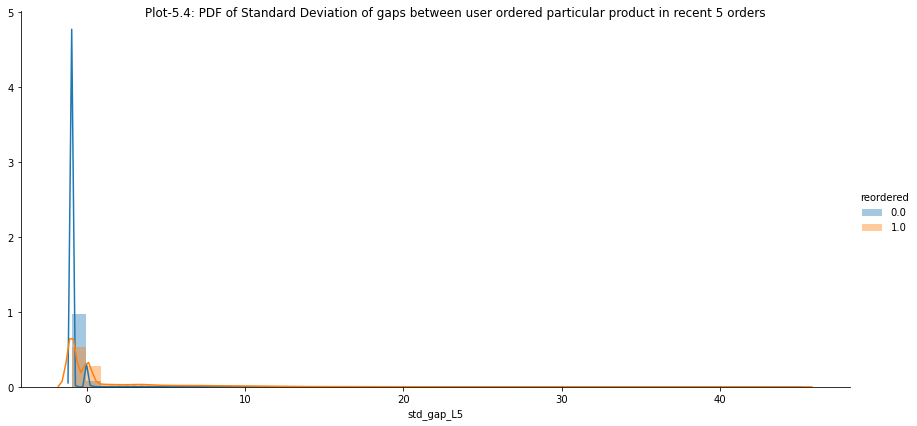

In [133]:
sns.FacetGrid(train_m3_std,hue='reordered',height=6,aspect=2).map(sns.distplot,'std_gap_L5').add_legend().fig.suptitle('Plot-5.4: PDF of Standard Deviation of gaps between user ordered particular product in recent 5 orders')

### Plot- 5.1,5.2,5.3,5.4:

* *These plots are PDF based on days gaps between user ordering a product in 5 recent orders. The intuition behind developing these features is that I have seen in some of the reference works that gaps between orders in last 5 orders were came out to be important. And also I observed days_since_prior_order could able to differentiate None(Orders without reorders) orders in EDA I did.*


* *Maximum and median gaps were the only features I observed in references but in addition to that I added mean and standard deviation.*


* *Through these plots it's evident that most number of products were not among or ordered only once in users 5 recent orders because we can observe peaks at -1 for all plots. I filled -1 for products that were not among recent 5 orders*

* *Distribution of all these plots is tailed.*


* *In plots 5.1,5.2,5.3 i.e., mean, median, max we can observe that for values greater than 0, reorders showed dominance even with high class imbalance.*


* *Plot 5.4(standard deviation) could not show any classifcation.*

### Joining for storing in DB

In [55]:
user_product_interraction_set_1=pd.merge(user_product_count_last5,mean_median_max_std_gap_L5,on=['user_id','product_id'],how='outer')

In [56]:
user_product_interraction_set_1[user_product_interreaction_set_1.isnull().any(axis=1)]

,user_id,product_id,u_p_count_L5,max_gap_L5,mean_gap_L5,median_gap_L5,std_gap_L5


In [58]:
user_product_interraction_set_1.head()

,user_id,product_id,u_p_count_L5,max_gap_L5,mean_gap_L5,median_gap_L5,std_gap_L5
0,1,196,5,30.0,16.0,17.0,10.86278
1,1,10258,5,30.0,16.0,17.0,10.86278
2,1,12427,5,30.0,16.0,17.0,10.86278
3,1,13032,2,44.0,44.0,44.0,0.00000
4,1,25133,5,30.0,16.0,17.0,10.86278


## ***10. Days since ordered last time train***

### *Considering today as day user is going to order(train), how many days back user purchased this product?*

In [62]:
query='''select order_id,user_id,product_id from prior_user_product_combo
union all
select order_id,user_id,product_id from final_train
'''
# This is for temporary purpose to fetch previous gap, attaching train with prior to see on what day of user is he/she ordering again.
data_for_joining_with_orders_refined=pd.read_sql_query(query,conn)

In [63]:
orders_refined=pd.read_sql_query("select * from orders_refined where eval_set!='test'",conn)

In [64]:
joined_for_previous_gap=pd.merge(orders_refined,data_for_joining_with_orders_refined,on=['order_id','user_id'],how='outer')

In [65]:
joined_for_previous_gap[joined_for_previous_gap.isnull().any(axis=1)]

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,order_day_of_user,product_id


In [66]:
# You can observe that all 18 products ordered so far by user_id=1 is attached at end with eval_set='train'
# We don't know whether user will purchase or not. day 191 ia considered as 'TODAY' of user_id=1 and before how many days product was ordered will be taken
joined_for_previous_gap[joined_for_previous_gap.user_id==1].tail(30)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,order_day_of_user,product_id
47,2295261,1,prior,9,1,16,147.0,25133
48,2295261,1,prior,9,1,16,147.0,46149
49,2295261,1,prior,9,1,16,147.0,49235
50,2550362,1,prior,10,4,8,177.0,196
51,2550362,1,prior,10,4,8,177.0,10258
52,2550362,1,prior,10,4,8,177.0,12427
53,2550362,1,prior,10,4,8,177.0,13032
54,2550362,1,prior,10,4,8,177.0,25133
55,2550362,1,prior,10,4,8,177.0,35951
56,2550362,1,prior,10,4,8,177.0,38928


In [67]:
def prev_gap(series): 
    # This function return how many days back an user ordered paticular product last time.
    try:
        return np.diff(series)[-1]
    except IndexError:
        # IndexError arises for test data(eval_set='test') as I did not include it so far.
        # Returning -1 for temporary purpose. Test will be included while implementing this feature for modelling and this problem will not arise
        return -1

In [68]:
%%time
temp=joined_for_previous_gap[['user_id','product_id','order_day_of_user']].groupby(['user_id','product_id']).agg({'order_day_of_user':prev_gap}).reset_index()
previous_gap=pd.DataFrame(temp.values,columns=['user_id','product_id','days_since_last_ordered'])
previous_gap.head()

CPU times: user 5min 45s, sys: 1.03 s, total: 5min 47s
Wall time: 5min 46s


,user_id,product_id,days_since_last_ordered
0,1.0,196.0,14.0
1,1.0,10258.0,14.0
2,1.0,10326.0,97.0
3,1.0,12427.0,14.0
4,1.0,13032.0,14.0


In [69]:
previous_gap[previous_gap.isnull().any(axis=1)]

,user_id,product_id,days_since_last_ordered


In [73]:
# Merging with train
train_prev_gap=pd.merge(train_set,previous_gap,on=['user_id','product_id'],how='left')

In [74]:
train_prev_gap[train_prev_gap.isnull().any(axis=1)]

,user_id,product_id,reordered,order_id,days_since_last_ordered


In [75]:
# You can observe that -1(Index error) is not present in train as I mentioned in function description
train_prev_gap[train_prev_gap.days_since_last_ordered==-1]

,user_id,product_id,reordered,order_id,days_since_last_ordered


Text(0.5, 0.98, 'Plot-6: PDF of Days since user last ordered a particular product')

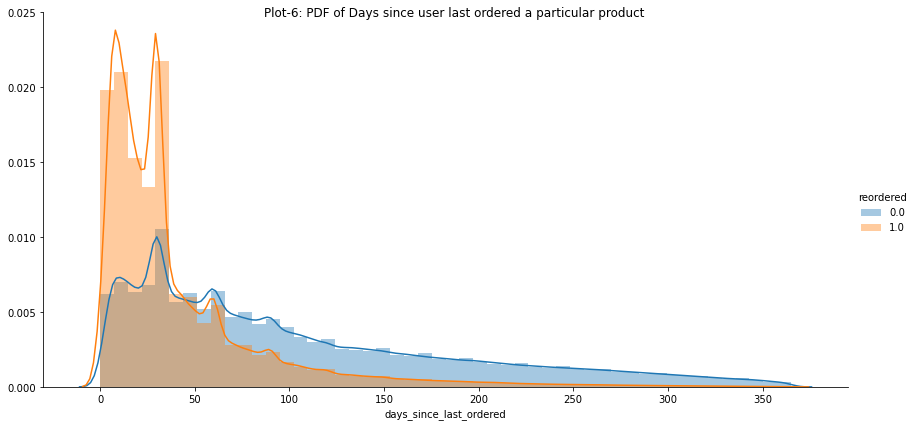

In [17]:
sns.FacetGrid(train_prev_gap,hue='reordered',height=6,aspect=2).map(sns.distplot,'days_since_last_ordered').add_legend().fig.suptitle('Plot-6: PDF of Days since user last ordered a particular product')

In [43]:
train_prev_max_gap=pd.merge(train_prev_gap,train_m3_std[['user_id','product_id','max_gap_L5']],on=['user_id','product_id'],how='left')

In [44]:
train_prev_max_gap[train_prev_max_gap.isnull().any(axis=1)]

,user_id,product_id,reordered,order_id,days_since_last_ordered,max_gap_L5


In [45]:
train_prev_max_gap['prev_max_gap_difference']=train_prev_max_gap.days_since_last_ordered-train_prev_max_gap.max_gap_L5
train_prev_max_gap.head()

,user_id,product_id,reordered,order_id,days_since_last_ordered,max_gap_L5,prev_max_gap_difference
0,1,196,1.0,1187899.0,14.0,30.0,-16.0
1,1,12427,0.0,1187899.0,14.0,30.0,-16.0
2,1,14084,0.0,1187899.0,190.0,-1.0,191.0
3,1,26088,1.0,1187899.0,175.0,-1.0,176.0
4,1,26405,1.0,1187899.0,125.0,-1.0,126.0


Text(0.5, 0.98, 'Plot-7: PDF of Difference of previous gap last 5 orders and maximum gap')

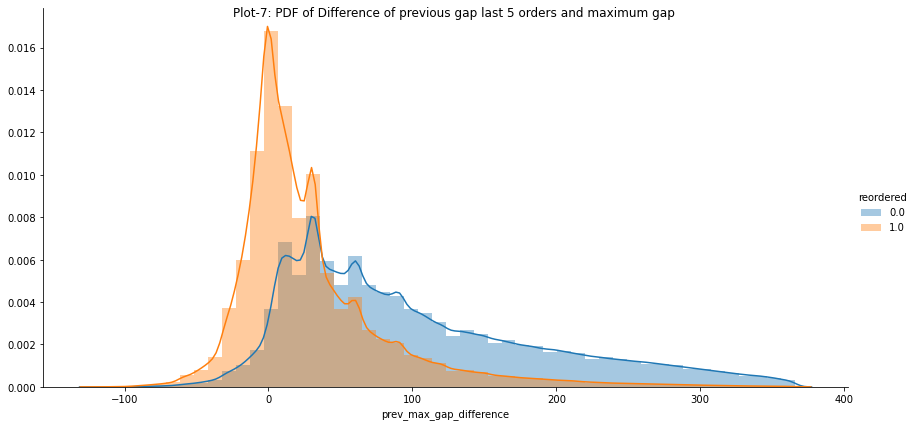

In [46]:
sns.FacetGrid(train_prev_max_gap,hue='reordered',height=6,aspect=2).map(sns.distplot,'prev_max_gap_difference').add_legend().fig.suptitle('Plot-7: PDF of Difference of previous gap last 5 orders and maximum gap')

In [ ]:
https://medium.com/kaggle-blog/instacart-market-basket-analysis-feda2700cded

### Plot-6,7:
    
* *Plot-6 is PDF of days since an user last ordered a particular product. This feature is extracted with an intuition that it may work well with mean,median and max gaps between order. i.e, for an example, if mean gap is 16 and days since an user last ordered is 16 then it may likely that user will reorder it today*

* *We can observe in plot-6 that products which have days since an user last ordered less than 50 days have high reorder scope and dominance of reorder decreased as days increased, which mean user may not reorder a product which is ordered very long ago.*


* *In the blog of 2nd place winner(https://medium.com/kaggle-blog/instacart-market-basket-analysis-feda2700cded), in insight-2 of reorder model we can observe that difference between days since last ordered the product and maximum days where user gone without purchasing product showed a clear classification.*
* *Taking Inspiration from this I checked the same(Plot-7) but I used maximum gap in last 5 orders by user instead of all orders and my plot showed similar behavior to Kazuki Ondera's plot.*
* *In plot-7 we can observe that the products with lesser previous and maximum gap between orders by users were more likely to be reordered.*

### Storing this days_since_last_ordered on train to DB

In [76]:
c.execute('create table days_since_last_ordered_train(user_id int, product_id int, days_since_last_ordered int)')
previous_gap.to_sql('days_since_last_ordered_train', conn, if_exists='replace', index = False)

## ***11. User-product ordering ratio after first encountering it in last 5 orders.***

### *Let user placed 10 orders so far. If user ordered a particular product for first time in order_number=2 and from that user ordered that product for 6 times then user_product_order_ratio_after_first_encounter is 6/9. Using this in perspective of previous 5 orders.*

In [20]:
%%time
# Fetching last order number of user for further use to develop this feature.
order_num_max=pd.read_sql_query("select user_id,max(order_number) as last_order_num from orders where eval_set='prior' group by user_id",conn)
order_num_max.head()

CPU times: user 1.97 s, sys: 43.4 ms, total: 2.01 s
Wall time: 2.04 s


,user_id,last_order_num
0,1,10
1,2,14
2,3,12
3,4,5
4,5,4


In [21]:
# Temporarly storing as I find easy to work with SQL.
c.execute('create table order_num_max(user_id int, last_order_num int)')
order_num_max.to_sql('order_num_max', conn, if_exists='replace', index = False)

In [80]:
%%time
query='''select tab_1.user_id,tab_1.product_id,((count(*)*1.0)/((tab_4.last_order_num-min(tab_2.order_number)+1)*1.0)) as u_p_ratio_aft_first_L5 from prior_user_product_combo tab_1
join (select order_id,order_number,order_day_of_user from orders_refined where eval_set='prior') tab_2 on (tab_1.order_id=tab_2.order_id)
join 
(select user_id,
case
when (max(order_number)-4)>0 then (max(order_number)-4)
else 1
end as fifth_recent_order_number from orders
where eval_set='prior'
group by user_id) tab_3 on (tab_1.user_id=tab_3.user_id and tab_2.order_number>=tab_3.fifth_recent_order_number)
join order_num_max tab_4 on tab_1.user_id=tab_4.user_id
group by tab_1.user_id,tab_1.product_id
'''
user_product_order_ratio_after_first_encounter=pd.read_sql_query(query,conn)

CPU times: user 3min 10s, sys: 16.1 s, total: 3min 26s
Wall time: 3min 27s


In [81]:
user_product_order_ratio_after_first_encounter[user_product_order_ratio_after_first_encounter.isnull().any(axis=1)]

,user_id,product_id,u_p_ratio_aft_first_L5


In [82]:
user_product_order_ratio_after_first_encounter.head()

,user_id,product_id,u_p_ratio_aft_first_L5
0,1,196,1.0
1,1,10258,1.0
2,1,12427,1.0
3,1,13032,0.5
4,1,25133,1.0


In [25]:
# Merging train set with user_product_order_ratio_after_first_encounter
train_reorder_ratio_first_encounter=pd.merge(train_set,user_product_order_ratio_after_first_encounter,on=['user_id','product_id'],how='left')

In [26]:
train_reorder_ratio_first_encounter[train_reorder_ratio_first_encounter.isnull().any(axis=1)]

,user_id,product_id,reordered,order_id,u_p_ratio_aft_first_L5
2,1,14084,0.0,1187899.0,NaN
3,1,26088,1.0,1187899.0,NaN
4,1,26405,1.0,1187899.0,NaN
7,1,13176,0.0,1187899.0,NaN
9,1,30450,0.0,1187899.0,NaN
...,...,...,...,...,...
8474636,206209,12376,0.0,272231.0,NaN
8474637,206209,14870,0.0,272231.0,NaN
8474638,206209,16066,0.0,272231.0,NaN
8474639,206209,17500,0.0,272231.0,NaN


In [27]:
train_reorder_ratio_first_encounter[train_reorder_ratio_first_encounter.u_p_ratio_aft_first_L5==0]

,user_id,product_id,reordered,order_id,u_p_ratio_aft_first_L5


In [28]:
# Nan values are for product not in recent 5 orders of user. Nan should be filled with 0.
train_reorder_ratio_first_encounter.fillna(0,inplace=True)

In [29]:
train_reorder_ratio_first_encounter.head()

,user_id,product_id,reordered,order_id,u_p_ratio_aft_first_L5
0,1,196,1.0,1187899.0,1.0
1,1,12427,0.0,1187899.0,1.0
2,1,14084,0.0,1187899.0,0.0
3,1,26088,1.0,1187899.0,0.0
4,1,26405,1.0,1187899.0,0.0


Text(0.5, 0.98, 'Plot-8: PDF of Order ratio of product after user first encounters it')

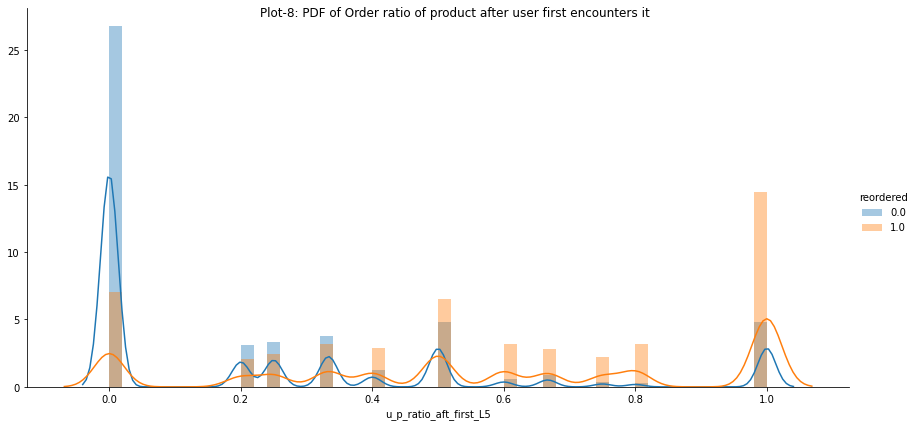

In [32]:
sns.FacetGrid(train_reorder_ratio_first_encounter,hue='reordered',height=6,aspect=2).map(sns.distplot,'u_p_ratio_aft_first_L5').add_legend().fig.suptitle('Plot-8: PDF of Order ratio of product after user first encounters it')

### Plot-8:

* *PLot-8 is PDF of ratio of user ordering a product after first encountering it in last 5 orders.*


* *This is taken with an intuition that user may have many orders so far but if user continious purchased a product after first purchasing it means that user review is positive towards that product and user can reorder it. For an example user may have 20 prior orders but if user purchased a product in order numbers 16,17,18,20(4 out of last 5) then user purchased a product 4 times after first encountering it in last 5 orders and user is more likely to reorder it in next order(order number-21(train))*


* *In Plot-8 we can observe that user-product with low reorder ratio first encountering it in last 5 orders are not highly reordered and reordering percentage increased as value increased. for values>0.5 we can observe that reorders are more even with high class imbalance.*

### Storing User-Product interraction features on recent 5 orders to Database

In [83]:
user_product_interraction_L5_set_1=pd.merge(user_product_interraction_set_1,user_product_order_ratio_after_first_encounter,on=['user_id','product_id'],how='outer')

In [84]:
user_product_interraction_L5_set_1[user_product_interraction_L5_set_1.isnull().any(axis=1)]

,user_id,product_id,u_p_count_L5,max_gap_L5,mean_gap_L5,median_gap_L5,std_gap_L5,u_p_ratio_aft_first_L5


In [85]:
user_product_interraction_L5_set_1.head()

,user_id,product_id,u_p_count_L5,max_gap_L5,mean_gap_L5,median_gap_L5,std_gap_L5,u_p_ratio_aft_first_L5
0,1,196,5,30.0,16.0,17.0,10.86278,1.0
1,1,10258,5,30.0,16.0,17.0,10.86278,1.0
2,1,12427,5,30.0,16.0,17.0,10.86278,1.0
3,1,13032,2,44.0,44.0,44.0,0.00000,0.5
4,1,25133,5,30.0,16.0,17.0,10.86278,1.0


In [86]:
c.execute('create table user_product_interraction_L5_set_1(user_id int, product_id int, u_p_count_L5 int, max_gap_L5 int, mean_gap_L5 decimal, median_gap_L5 decimal, std_gap_L5 decimal, u_p_ratio_aft_first_L5 decimal)')
user_product_interraction_L5_set_1.to_sql('user_product_interraction_L5_set_1', conn, if_exists='replace', index = False)

## ***12. Number of times user purchased a product***

In [5]:
%%time
query='''select user_id,product_id,count(*) as u_p_count from prior_user_product_combo
group by user_id,product_id
'''
number_of_times_user_ordered_product=pd.read_sql_query(query,conn)

CPU times: user 46.6 s, sys: 1.82 s, total: 48.4 s
Wall time: 49.9 s


In [6]:
number_of_times_user_ordered_product.head()

,user_id,product_id,u_p_count
0,1,196,10
1,1,10258,9
2,1,10326,1
3,1,12427,10
4,1,13032,3


In [7]:
# Merging with train
train_order_count=pd.merge(train_set,number_of_times_user_ordered_product,on=['user_id','product_id'],how='left')
train_order_count.head()

,user_id,product_id,reordered,order_id,u_p_count
0,1,196,1.0,1187899.0,10
1,1,12427,0.0,1187899.0,10
2,1,14084,0.0,1187899.0,1
3,1,26088,1.0,1187899.0,2
4,1,26405,1.0,1187899.0,2


In [8]:
train_order_count[train_order_count.isnull().any(axis=1)]

,user_id,product_id,reordered,order_id,u_p_count


In [11]:
train_order_count.u_p_count.describe()

count    8.474661e+06
mean     2.435731e+00
std      3.549315e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      9.900000e+01
Name: u_p_count, dtype: float64

Text(0.5, 0.98, 'Plot-9: PDF of total number of times user ordered a product')

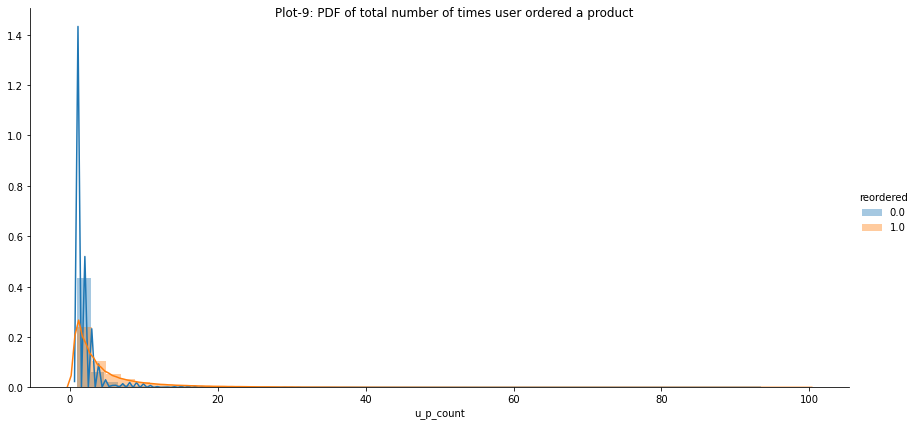

In [10]:
sns.FacetGrid(train_order_count,hue='reordered',height=6,aspect=2).map(sns.distplot,'u_p_count').add_legend().fig.suptitle('Plot-9: PDF of total number of times user ordered a product')

### Plot-9:

* *This is the PDF of total number of times user ordered a product. Minimum is 1 and maximum is 99 which means there are cases where users ordered a product in all of thier orders. We know that maximum number of prior orders in this data is 99 and there are cases where user ordered a product in all 99 of his/her orders.*

* *This did not classify data as order count in recent 5 orders did. We can observe slight higher reorders as value increases but this is not as significant as order count in recent 5 orders did.*

## ***13. Maximum, Mean, Median and Standard Deviation of gaps(days between product ordered.)***

In [9]:
def maximum_gap(series): 
    # This function returns maximum of gaps between an user ordering a product
    # For example an user ordered a product on day 1,5,9,17 than max(gaps)=8 is gap between 9th and 17th day.
    try:
        return np.diff(series).max()
    except ValueError:
        # Value error arises when user ordered product for only 1 item in last 5 orders.
        # np.diff([1]).max() raises ValueError as np.diff([1]) return empty array
        # returning any positive number or 0 in this case is not logically correct.
        # so returing -1 specifies that product is ordered only once and there no scope to compare for maximum gap.
        return -1

In [10]:
def mean_gap(series): 
    # This function returns mean of gaps between an user ordering a product
    mean_gap=np.diff(series).mean()
    if math.isnan(mean_gap):
        # Unlike ValueError in maximum_gap, np.diff([1]).mean() return Nan
        return -1
    else:
        return mean_gap 

In [11]:
def median_gap(series): 
    # This function returns median of gaps between an user ordering a product
    median_gap=np.median(np.diff(series))
    if math.isnan(median_gap):
        # Unlike ValueError in maximum_gap, np.median(np.diff([1])) return Nan
        return -1
    else:
        return median_gap 

In [12]:
def std_gap(series):
    # This function returns Standard Deviarion of gaps between an user ordering a product
    std_gap=np.diff(series).std()
    if math.isnan(std_gap):
        # Unlike ValueError in maximum_gap, np.diff([1]).std() return Nan
        return -1
    else:
        return std_gap 

In [13]:
%%time
query='''select * from prior_user_product_combo tab_1
left join (select order_id,order_day_of_user from orders_refined) tab_2 on tab_1.order_id=tab_2.order_id
'''
prior_with_ordered_day=pd.read_sql_query(query,conn)

CPU times: user 2min 5s, sys: 19.4 s, total: 2min 24s
Wall time: 2min 24s


In [14]:
prior_with_ordered_day[prior_with_ordered_day.isnull().any(axis=1)]

,order_id,user_id,product_id,add_to_cart_order,reordered,order_id,order_day_of_user


In [15]:
prior_with_ordered_day.head()

,order_id,user_id,product_id,add_to_cart_order,reordered,order_id,order_day_of_user
0,2539329,1,196,1,0,2539329,1.0
1,2539329,1,12427,3,0,2539329,1.0
2,2539329,1,14084,2,0,2539329,1.0
3,2539329,1,26088,4,0,2539329,1.0
4,2539329,1,26405,5,0,2539329,1.0


In [16]:
prior_with_ordered_day[prior_with_ordered_day.user_id==1]

,order_id,user_id,product_id,add_to_cart_order,reordered,order_id,order_day_of_user
0,2539329,1,196,1,0,2539329,1.0
1,2539329,1,12427,3,0,2539329,1.0
2,2539329,1,14084,2,0,2539329,1.0
3,2539329,1,26088,4,0,2539329,1.0
4,2539329,1,26405,5,0,2539329,1.0
5,2398795,1,196,1,1,2398795,16.0
6,2398795,1,10258,2,0,2398795,16.0
7,2398795,1,12427,3,1,2398795,16.0
8,2398795,1,13032,6,0,2398795,16.0
9,2398795,1,13176,4,0,2398795,16.0


In [17]:
%%time
grouped=prior_with_ordered_day[['user_id','product_id','order_day_of_user']].groupby(['user_id','product_id']).agg({'order_day_of_user':[maximum_gap,mean_gap,median_gap,std_gap]}).reset_index()
max_mean_median_std_gaps=pd.DataFrame(grouped.values,columns=['user_id','product_id','max_gap','mean_gap','median_gap','std_gap'])
max_mean_median_std_gaps.head()

CPU times: user 51min 12s, sys: 10.2 s, total: 51min 22s
Wall time: 51min 13s


,user_id,product_id,max_gap,mean_gap,median_gap,std_gap
0,1.0,196.0,30.0,19.555556,20.0,8.858281
1,1.0,10258.0,30.0,20.125000,20.5,9.239014
2,1.0,10326.0,-1.0,-1.000000,-1.0,-1.000000
3,1.0,12427.0,30.0,19.555556,20.0,8.858281
4,1.0,13032.0,117.0,80.500000,80.5,36.500000


In [18]:
max_mean_median_std_gaps[max_mean_median_std_gaps.isnull().any(axis=1)]

,user_id,product_id,max_gap,mean_gap,median_gap,std_gap


In [19]:
#Merging with train
train_m3_std_gaps=pd.merge(train_set,max_mean_median_std_gaps,on=['user_id','product_id'],how='left')

In [20]:
train_m3_std_gaps[train_m3_std_gaps.isnull().any(axis=1)]

,user_id,product_id,reordered,order_id,max_gap,mean_gap,median_gap,std_gap


In [21]:
train_m3_std_gaps.head()

,user_id,product_id,reordered,order_id,max_gap,mean_gap,median_gap,std_gap
0,1,196,1.0,1187899.0,30.0,19.555556,20.0,8.858281
1,1,12427,0.0,1187899.0,30.0,19.555556,20.0,8.858281
2,1,14084,0.0,1187899.0,-1.0,-1.000000,-1.0,-1.000000
3,1,26088,1.0,1187899.0,15.0,15.000000,15.0,0.000000
4,1,26405,1.0,1187899.0,65.0,65.000000,65.0,0.000000


Text(0.5, 0.98, 'Plot-10.1: PDF of maximum gap of user ordered particular product')

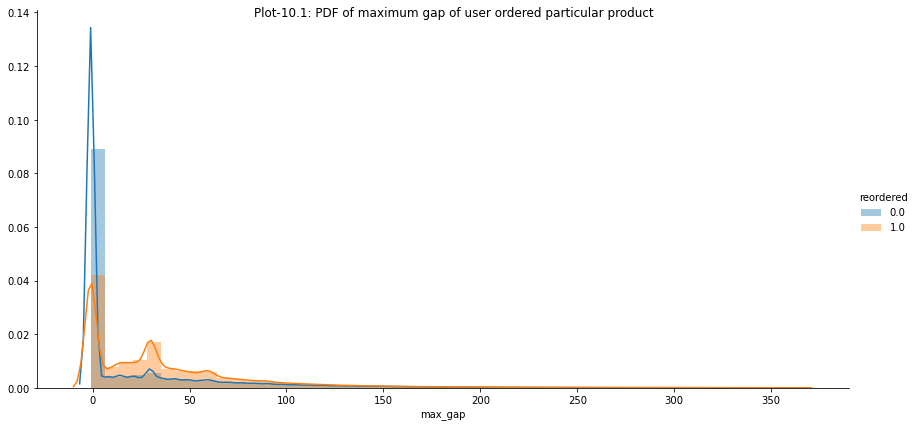

In [22]:
sns.FacetGrid(train_m3_std_gaps,hue='reordered',height=6,aspect=2).map(sns.distplot,'max_gap').add_legend().fig.suptitle('Plot-10.1: PDF of maximum gap of user ordered particular product')

Text(0.5, 0.98, 'Plot-10.2: PDF of mean of gaps between user ordered particular product')

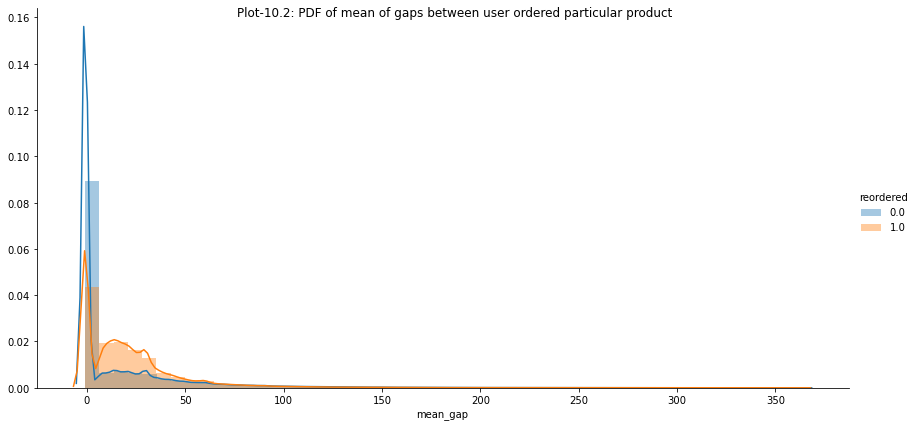

In [23]:
sns.FacetGrid(train_m3_std_gaps,hue='reordered',height=6,aspect=2).map(sns.distplot,'mean_gap').add_legend().fig.suptitle('Plot-10.2: PDF of mean of gaps between user ordered particular product')

Text(0.5, 0.98, 'Plot-10.3: PDF of median of gaps between user ordered particular product')

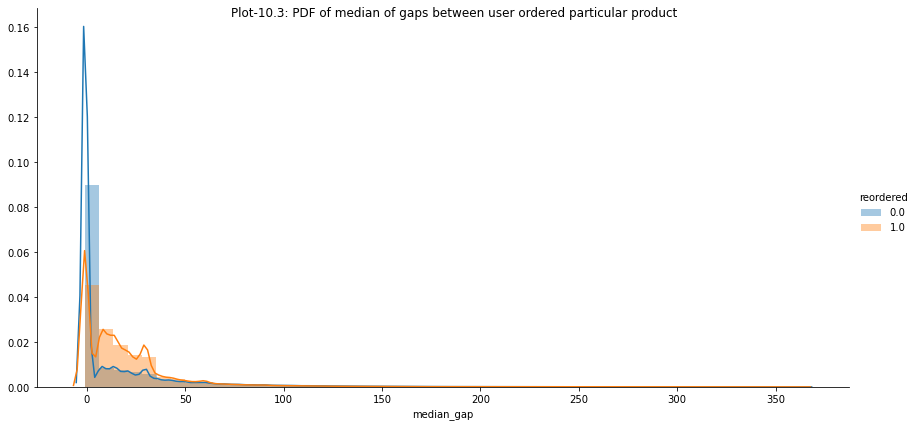

In [24]:
sns.FacetGrid(train_m3_std_gaps,hue='reordered',height=6,aspect=2).map(sns.distplot,'median_gap').add_legend().fig.suptitle('Plot-10.3: PDF of median of gaps between user ordered particular product')

Text(0.5, 0.98, 'Plot-10.4: PDF of Standard Deviation of gaps between user ordered particular product')

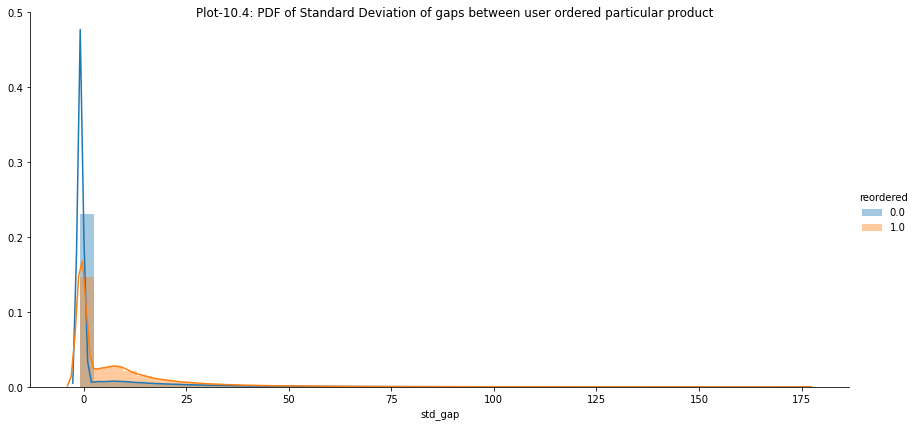

In [25]:
sns.FacetGrid(train_m3_std_gaps,hue='reordered',height=6,aspect=2).map(sns.distplot,'std_gap').add_legend().fig.suptitle('Plot-10.4: PDF of Standard Deviation of gaps between user ordered particular product')

### Plot-10.1,10.2,10.3,10.4:

* *These PDF are of feaures based on number of days between products ordered. I fetched these features already for recent 5 orders of every user and now I am taking the same features on whole(all orders of users).*


* *When compared to these features on only recent 5 orders, same features on whole data(all orders of users) showing better classification.*


* *we can observe that in all 4 plots(especially mean and median gaps) reorders are dominant as respective values increase . Classification not so significant but it is significant when compared with same features on only recent 5 orders of users.*

### Joining for storing in DB

In [33]:
user_product_interraction_features_set_1=pd.merge(number_of_times_user_ordered_product,max_mean_median_std_gaps,on=['user_id','product_id'],how='outer')

In [34]:
user_product_interraction_features_set_1[user_product_interraction_features_set_1.isnull().any(axis=1)]

,user_id,product_id,u_p_count,max_gap,mean_gap,median_gap,std_gap


In [35]:
user_product_interraction_features_set_1.head()

,user_id,product_id,u_p_count,max_gap,mean_gap,median_gap,std_gap
0,1,196,10,30.0,19.555556,20.0,8.858281
1,1,10258,9,30.0,20.125000,20.5,9.239014
2,1,10326,1,-1.0,-1.000000,-1.0,-1.000000
3,1,12427,10,30.0,19.555556,20.0,8.858281
4,1,13032,3,117.0,80.500000,80.5,36.500000


## ***14. User-product ordering ratio after first encountering***

In [26]:
%%time
query='''select tab_1.user_id,tab_1.product_id,((count(*)*1.0)/((tab_3.last_order_num-min(tab_2.order_number)+1)*1.0)) as u_p_ratio_aft_first from prior_user_product_combo tab_1
join (select order_id,order_number,order_day_of_user from orders_refined where eval_set='prior') tab_2 on (tab_1.order_id=tab_2.order_id)
join order_num_max tab_3 on tab_1.user_id=tab_3.user_id
group by tab_1.user_id,tab_1.product_id
'''
user_product_order_ratio_after_first_encounter=pd.read_sql_query(query,conn)

CPU times: user 1min 50s, sys: 32 s, total: 2min 22s
Wall time: 2min 30s


In [27]:
user_product_order_ratio_after_first_encounter[user_product_order_ratio_after_first_encounter.isnull().any(axis=1)]

,user_id,product_id,u_p_ratio_aft_first


In [28]:
user_product_order_ratio_after_first_encounter.head()

,user_id,product_id,u_p_ratio_aft_first
0,1,196,1.000000
1,1,10258,1.000000
2,1,10326,0.166667
3,1,12427,1.000000
4,1,13032,0.333333


In [29]:
# Merging with train
train_order_ratio_first_encounter=pd.merge(train_set,user_product_order_ratio_after_first_encounter,on=['user_id','product_id'],how='left')

In [30]:
train_order_ratio_first_encounter[train_order_ratio_first_encounter.isnull().any(axis=1)]

,user_id,product_id,reordered,order_id,u_p_ratio_aft_first


In [31]:
train_order_ratio_first_encounter.head()

,user_id,product_id,reordered,order_id,u_p_ratio_aft_first
0,1,196,1.0,1187899.0,1.0
1,1,12427,0.0,1187899.0,1.0
2,1,14084,0.0,1187899.0,0.1
3,1,26088,1.0,1187899.0,0.2
4,1,26405,1.0,1187899.0,0.2


Text(0.5, 0.98, 'Plot-11: PDF of Order ratio of product after user first encounters it(whole data)')

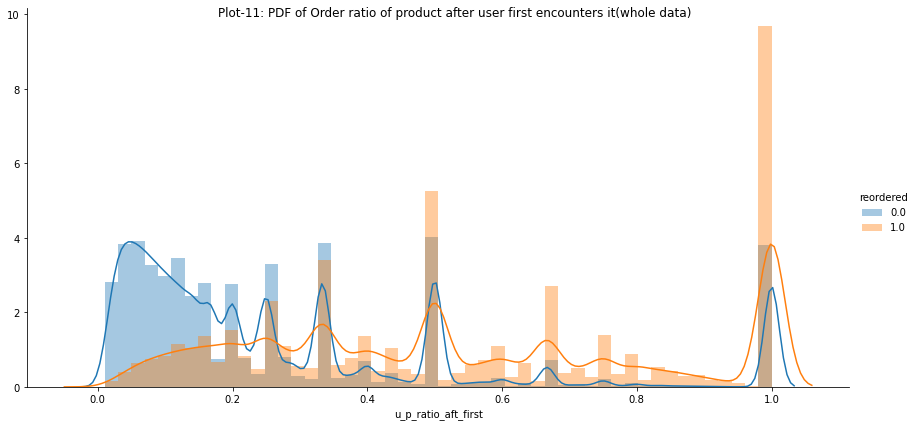

In [32]:
sns.FacetGrid(train_order_ratio_first_encounter,hue='reordered',height=6,aspect=2).map(sns.distplot,'u_p_ratio_aft_first').add_legend().fig.suptitle('Plot-11: PDF of Order ratio of product after user first encounters it(whole data)')

### Plot-11:

* *PLot-11 is PDF of ratio of user ordering a product after first encountering it. I already developed this feature on recent 5 orders but here I took it on all orders of an user.*


* *We can observe that user-product with low reorder ratio first encountering it are not highly reordered and reordering percentage increased as value increased. for values>0.5 we can observe that reorders are more even with high class imbalance. Even for values <0.5 and >0.25 reordering dominated. *

## ***15. Streak(In how many orders user continuously purchased a product?)***

In [36]:
query='''select tab_1.user_id,tab_1.product_id,tab_2.order_number from prior_user_product_combo tab_1
join (select order_id,order_number from orders) tab_2 on tab_1.order_id=tab_2.order_id
'''
user_product_number=pd.read_sql_query(query,conn)

In [38]:
user_product_number[user_product_number.isnull().any(axis=1)]

,user_id,product_id,order_number


In [39]:
user_product_number.head()

,user_id,product_id,order_number
0,1,196,1
1,1,12427,1
2,1,14084,1
3,1,26088,1
4,1,26405,1


In [45]:
user_product_number[(user_product_number.user_id==1)&(user_product_number.product_id==46149)]
# The streak here is 3 as the product was ordered consecutively in 3 orders.

,user_id,product_id,order_number
42,1,46149,8
48,1,46149,9
58,1,46149,10


In [47]:
user_product_number[(user_product_number.user_id==1)&(user_product_number.product_id==13032)]
# The streak here is 1 as the product was not ordered consecutively.

,user_id,product_id,order_number
8,1,13032,2
36,1,13032,7
53,1,13032,10


In [37]:
#https://stackoverflow.com/questions/2154249/identify-groups-of-continuous-numbers-in-a-list#:~:text=The%20key%20to%20the%20solution,all%20appear%20in%20same%20group.&text=groupby%20groups%20elements%20by%20equal,grouped%20together%20and%20so%20forth.


def streak(series):
    #This function return maximum of streak of user ordering a particular product.
    #For suppose user ordered a product in order_numbers 2,3,5,6,7,9 then streak 5,6,7 is longest and function returns 3.
    #This code snippet was learnt from above mentioned link as I was struck thinking about how to do it I found for a way on StackOverflow
    groups=[]
    for k,g in groupby(enumerate(series.tolist()), lambda x: x[0]-x[1]):
        groups.append(list(map(itemgetter(1), g)))
    return max([len(i) for i in groups])

In [50]:
%%time
streak=user_product_number.groupby(['user_id','product_id']).agg({'order_number':streak}).reset_index()
user_product_streak=pd.DataFrame(streak.values,columns=['user_id','product_id','streak'])
user_product_streak.head()

CPU times: user 2min 49s, sys: 913 ms, total: 2min 50s
Wall time: 2min 50s


,user_id,product_id,streak
0,1,196,10
1,1,10258,9
2,1,10326,1
3,1,12427,10
4,1,13032,1


In [51]:
user_product_streak[user_product_streak.isnull().any(axis=1)]

,user_id,product_id,streak


In [52]:
user_product_streak[(user_product_streak.user_id==1)&(user_product_streak.product_id==46149)]
#This is for checking with above examples

,user_id,product_id,streak
16,1,46149,3


In [53]:
user_product_streak[(user_product_streak.user_id==1)&(user_product_streak.product_id==13032)]
#This is for checking with above examples

,user_id,product_id,streak
4,1,13032,1


In [54]:
#Merging with train
train_streak=pd.merge(train_set,user_product_streak,on=['user_id','product_id'],how='left')

In [55]:
train_streak[train_streak.isnull().any(axis=1)]

,user_id,product_id,reordered,order_id,streak


In [56]:
train_streak.head()

,user_id,product_id,reordered,order_id,streak
0,1,196,1.0,1187899.0,10
1,1,12427,0.0,1187899.0,10
2,1,14084,0.0,1187899.0,1
3,1,26088,1.0,1187899.0,2
4,1,26405,1.0,1187899.0,1


In [63]:
train_streak.streak.describe()

count    8.474661e+06
mean     1.450903e+00
std      1.374987e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      9.900000e+01
Name: streak, dtype: float64

In [72]:
streak_train=train_streak.streak
for percentile in [80,85,90,95,96,97,98,99,99.6]:
    print('{} percentile: {}'.format(percentile,np.percentile(streak_train,percentile)))

80 percentile: 2.0
85 percentile: 2.0
90 percentile: 2.0
95 percentile: 3.0
96 percentile: 4.0
97 percentile: 4.0
98 percentile: 5.0
99 percentile: 7.0
99.6 percentile: 10.0


Text(0.5, 0.98, 'Plot-12: PDF of Streak<=10(Maximum of consecutive orders in which product was ordered by user)')

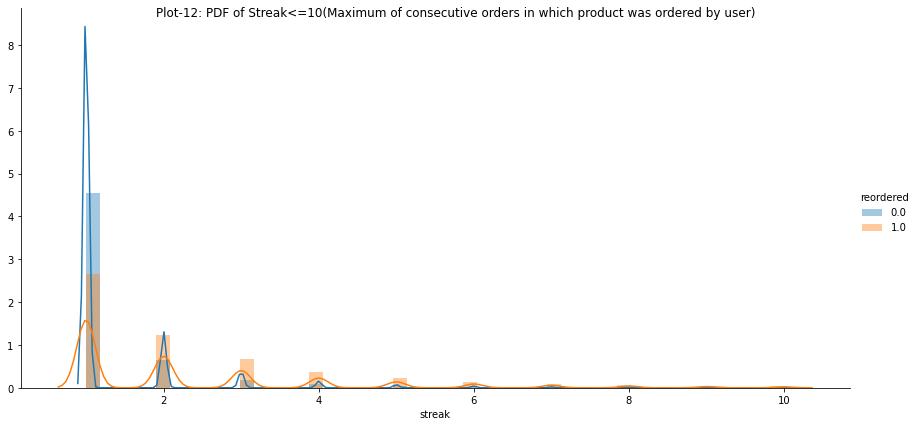

In [73]:
sns.FacetGrid(train_streak[train_streak.streak<=10],hue='reordered',height=6,aspect=2).map(sns.distplot,'streak').add_legend().fig.suptitle('Plot-12: PDF of Streak<=10(Maximum of consecutive orders in which product was ordered by user)')

### Plot-12:

* *This plot-12 is PDF of Streak. Streak is the Maximum number of consecutive orders in which an user ordered a product.*

* *I plotted only for streak<=10 because you can observe that 99.65 of data have streak<=10 and plotting for greater than that made plot look clumsy.*

* *As per my observation from this plot, Streak could not able to classify data clearly and peak of class=0(not reordered) at 0 is beacause on high class imbalance.*

### Joining for storing in db

In [74]:
user_product_interraction_features_set_2=pd.merge(user_product_order_ratio_after_first_encounter,user_product_streak,on=['user_id','product_id'],how='outer')

In [75]:
user_product_interraction_features_set_2[user_product_interraction_features_set_2.isnull().any(axis=1)]

,user_id,product_id,u_p_ratio_aft_first,streak


In [76]:
user_product_interraction_features_set_2.head()

,user_id,product_id,u_p_ratio_aft_first,streak
0,1,196,1.000000,10
1,1,10258,1.000000,9
2,1,10326,0.166667,1
3,1,12427,1.000000,10
4,1,13032,0.333333,1


### Storing User_Product interraction features in Database

In [77]:
user_product_interraction_features_set_1=pd.merge(user_product_interraction_features_set_1,user_product_interraction_features_set_2,on=['user_id','product_id'],how='outer')

In [78]:
user_product_interraction_features_set_1[user_product_interraction_features_set_1.isnull().any(axis=1)]

,user_id,product_id,u_p_count,max_gap,mean_gap,median_gap,std_gap,u_p_ratio_aft_first,streak


In [79]:
user_product_interraction_features_set_1.head()

,user_id,product_id,u_p_count,max_gap,mean_gap,median_gap,std_gap,u_p_ratio_aft_first,streak
0,1,196,10,30.0,19.555556,20.0,8.858281,1.000000,10
1,1,10258,9,30.0,20.125000,20.5,9.239014,1.000000,9
2,1,10326,1,-1.0,-1.000000,-1.0,-1.000000,0.166667,1
3,1,12427,10,30.0,19.555556,20.0,8.858281,1.000000,10
4,1,13032,3,117.0,80.500000,80.5,36.500000,0.333333,1


In [80]:
c.execute('create table user_product_interraction_set_1(user_id int, product_id int, u_p_count int, max_gap int, mean_gap decimal, median_gap decimal, std_gap decimal, u_p_ratio_aft_first decimal,streak int)')
user_product_interraction_features_set_1.to_sql('user_product_interraction_set_1', conn, if_exists='replace', index = False)

## ***16. What's the similarity between a product and top_3 most ordered products by an user? (Features using Singular Value Decompositon)***

*Let suppose an user's most ordered products are products A,B,C. Here in this feature we take cosine similarity of a product with that A,B,C products of an user.*

In [5]:
%%time
query='''select user_id,product_id,count(*) as u_p_count from prior_user_product_combo
group by user_id,product_id
'''
number_of_times_user_ordered_product=pd.read_sql_query(query,conn)

CPU times: user 45.1 s, sys: 1.46 s, total: 46.6 s
Wall time: 46.8 s


In [6]:
number_of_times_user_ordered_product.head()

,user_id,product_id,u_p_count
0,1,196,10
1,1,10258,9
2,1,10326,1
3,1,12427,10
4,1,13032,3


In [7]:
u_p_adj_matrix=csr_matrix((number_of_times_user_ordered_product.u_p_count.values, (number_of_times_user_ordered_product.user_id.values,number_of_times_user_ordered_product.product_id.values)),)
u_p_adj_matrix.shape

(206210, 49689)

In [8]:
print('No. of unique users in the data: {}'.format(pd.read_sql_query('select distinct(user_id) from orders',conn).shape[0]))
print('No. of unique products in the data: {}'.format(pd.read_sql_query('select distinct(product_id) from order_products__prior',conn).shape[0]))

No. of unique users in the data: 206209
No. of unique products in the data: 49677


*Adjacency Matrix is formed in such a way that each row corresponds to an user and each column corresponds to a product and interraction element of user and product is number of times user ordered that product. Number of columns in adjacency matrix is more than number of unique products, it is because on non consecutive product_id numbers.*

In [13]:
%%time
# Taking 50 dimensional representation for each user and product.
U, Sigma, VT = randomized_svd(u_p_adj_matrix, n_components=50,n_iter=100, random_state=None)
print(U.shape)
print(Sigma.shape)
print(VT.T.shape)

(206210, 50)
(50,)
(49689, 50)
CPU times: user 4min 14s, sys: 2min 59s, total: 7min 13s
Wall time: 3min 34s


In [60]:
# Dividing by magnitude to get unit vectors as I am going to fetch Cosine Similarity with Dot product. 
# So the Dot product depends only on angle between vectors instead of magnitudes.
user_unit_vectors=np.array([i/np.linalg.norm(i) for i in tqdm(U)])
products_unit_vectors=np.array([i/np.linalg.norm(i) for i in tqdm(VT.T)])

100%|██████████| 49689/49689 [00:00<00:00, 104266.64it/s]


In [14]:
%%time
query='''select user_id,product_id,count(*) as u_p_count from prior_user_product_combo
group by user_id,product_id
order by u_p_count desc
'''
# This query fetches user,product and number of times user purchased the product in descending order.
number_of_times_user_ordered_product_sorted=pd.read_sql_query(query,conn)

CPU times: user 51.7 s, sys: 1.75 s, total: 53.5 s
Wall time: 53.5 s


In [20]:
def top_3(series):
    # This function pics top 3 most ordered products of an user.
    # It fails when all the number of orders are same.
    # For an example, if user ordered A,B,C,D all 5 times each then this function will miss one product.
    return series.tolist()[0:3]

In [26]:
%%time
top_3_products_by_users=number_of_times_user_ordered_product_sorted.groupby('user_id').agg({'product_id':top_3}).reset_index()

CPU times: user 2.74 s, sys: 94.2 ms, total: 2.84 s
Wall time: 2.84 s


In [37]:
temp=[]
for i in tqdm(top_3_products_by_users.values):
    if len(i[1])==3:
        temp.append([i[0]]+i[1])
    elif len(i[1])==2:
        #If user ordered only 2 products so far then we place that 2nd most ordered product as 3rd most too.
        temp.append([i[0]]+i[1]+[i[1][1]])
    elif len(i[1])==1:
        #If user purchased only 1 product so far then that product will be top-1,2,3 of user.
        #I am doing this to avoid null values.
        temp.append([i[0]]+(i[1]*3))

100%|██████████| 206209/206209 [00:00<00:00, 513545.60it/s]


In [38]:
top_3_products_of_user=pd.DataFrame(temp,columns=['user_id','top_1_product','top_2_product','top_3_product'])
top_3_products_of_user.head()

,user_id,top_1_product,top_2_product,top_3_product
0,1,196,12427,10258
1,2,32792,47209,24852
2,3,39190,47766,21903
3,4,35469,1200,2707
4,5,11777,26604,24535


In [43]:
top_3_products_of_user_with_unique_products=pd.merge(top_3_products_of_user,pd.read_sql_query('select distinct user_id,product_id from prior_user_product_combo',conn),on='user_id',how='left')

In [44]:
top_3_products_of_user_with_unique_products[top_3_products_of_user_with_unique_products.user_id==1]
#Joined unique products ordered by user to fetch similarity

,user_id,top_1_product,top_2_product,top_3_product,product_id
0,1,196,12427,10258,196
1,1,196,12427,10258,12427
2,1,196,12427,10258,14084
3,1,196,12427,10258,26088
4,1,196,12427,10258,26405
5,1,196,12427,10258,10258
6,1,196,12427,10258,13032
7,1,196,12427,10258,13176
8,1,196,12427,10258,25133
9,1,196,12427,10258,30450


In [45]:
top_3_products_of_user_with_unique_products[top_3_products_of_user_with_unique_products.isnull().any(axis=1)]

,user_id,top_1_product,top_2_product,top_3_product,product_id


In [77]:
similarity_with_top_3=[]
for i in tqdm(top_3_products_of_user_with_unique_products.values):
    #Computing Dot product or Cosine Similarity of product vector with top-1,2,3 products of user
    dot=[np.dot(products_unit_vectors[i[-1]],products_unit_vectors[i[1]]),np.dot(products_unit_vectors[i[-1]],products_unit_vectors[i[2]]),np.dot(products_unit_vectors[i[-1]],products_unit_vectors[i[3]])]
    similarity_with_top_3.append([i[0]]+[i[-1]]+dot)

100%|██████████| 13307953/13307953 [02:18<00:00, 95937.87it/s] 


In [78]:
user_prod_sim_with_top_3=pd.DataFrame(similarity_with_top_3,columns=['user_id','product_id','top_1_sim','top_2_sim','top_3_sim'])
user_prod_sim_with_top_3.head()

,user_id,product_id,top_1_sim,top_2_sim,top_3_sim
0,1,196,1.000000,0.934235,0.905963
1,1,12427,0.934235,1.000000,0.985929
2,1,14084,0.089207,0.106976,0.122681
3,1,26088,0.607246,0.798108,0.845998
4,1,26405,0.534592,0.745773,0.790627


In [79]:
user_prod_sim_with_top_3[user_prod_sim_with_top_3.user_id==1]
#We can observe that for user_id=1 the top 1 ordered product is product_id=196.
#Here similarity of product_id=196 with top-1 product is 1 which does mean angle between vectors is zero which means they are same.

,user_id,product_id,top_1_sim,top_2_sim,top_3_sim
0,1,196,1.000000,0.934235,0.905963
1,1,12427,0.934235,1.000000,0.985929
2,1,14084,0.089207,0.106976,0.122681
3,1,26088,0.607246,0.798108,0.845998
4,1,26405,0.534592,0.745773,0.790627
5,1,10258,0.905963,0.985929,1.000000
6,1,13032,0.854120,0.951201,0.949032
7,1,13176,-0.016817,0.030578,-0.014451
8,1,25133,-0.044080,0.009676,0.038472
9,1,30450,0.286367,0.445493,0.497303


In [80]:
user_prod_sim_with_top_3[user_prod_sim_with_top_3.isnull().any(axis=1)]

,user_id,product_id,top_1_sim,top_2_sim,top_3_sim


In [82]:
#Merging with train
train_top_3_sim_products=pd.merge(train_set,user_prod_sim_with_top_3,on=['user_id','product_id'],how='left')

In [83]:
train_top_3_sim_products[train_top_3_sim_products.isnull().any(axis=1)]

,user_id,product_id,reordered,order_id,top_1_sim,top_2_sim,top_3_sim


In [84]:
train_top_3_sim_products.head()

,user_id,product_id,reordered,order_id,top_1_sim,top_2_sim,top_3_sim
0,1,196,1.0,1187899.0,1.000000,0.934235,0.905963
1,1,12427,0.0,1187899.0,0.934235,1.000000,0.985929
2,1,14084,0.0,1187899.0,0.089207,0.106976,0.122681
3,1,26088,1.0,1187899.0,0.607246,0.798108,0.845998
4,1,26405,1.0,1187899.0,0.534592,0.745773,0.790627


In [86]:
train_top_3_sim_products['max_sim_t3']=[max(i) for i in train_top_3_sim_products[['top_1_sim','top_2_sim','top_3_sim']].values]
train_top_3_sim_products['sum_of_sim_t3']=train_top_3_sim_products.top_1_sim+train_top_3_sim_products.top_2_sim+train_top_3_sim_products.top_3_sim
train_top_3_sim_products.head()
#Took maximum and sum of top 3 similarities

,user_id,product_id,reordered,order_id,top_1_sim,top_2_sim,top_3_sim,max_sim_t3,sum_of_sim_t3
0,1,196,1.0,1187899.0,1.000000,0.934235,0.905963,1.000000,2.840198
1,1,12427,0.0,1187899.0,0.934235,1.000000,0.985929,1.000000,2.920164
2,1,14084,0.0,1187899.0,0.089207,0.106976,0.122681,0.122681,0.318864
3,1,26088,1.0,1187899.0,0.607246,0.798108,0.845998,0.845998,2.251352
4,1,26405,1.0,1187899.0,0.534592,0.745773,0.790627,0.790627,2.070992


*If maximum similarity(max_sim_t3) is 1 then the product is among top-3 most ordered products by user.*

In [87]:
train_top_3_sim_products[train_top_3_sim_products.isnull().any(axis=1)]

,user_id,product_id,reordered,order_id,top_1_sim,top_2_sim,top_3_sim,max_sim_t3,sum_of_sim_t3


Text(0.5, 0.98, 'Plot-13.1: PDF of Maximum Cosine Similarity of product with top_3 most ordered products by user')

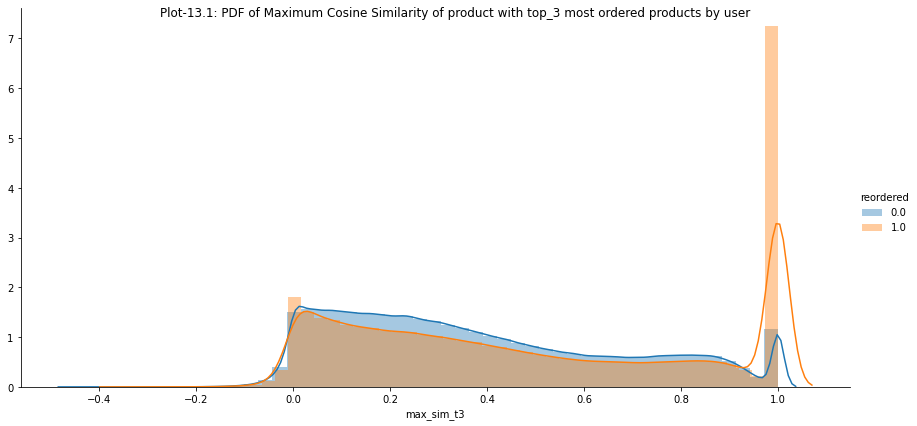

In [88]:
sns.FacetGrid(train_top_3_sim_products,hue='reordered',height=6,aspect=2).map(sns.distplot,'max_sim_t3').add_legend().fig.suptitle('Plot-13.1: PDF of Maximum Cosine Similarity of product with top_3 most ordered products by user')

Text(0.5, 0.98, 'Plot-13.2: PDF of Sum of Cosine Similarities of product with top_3 most ordered products by user')

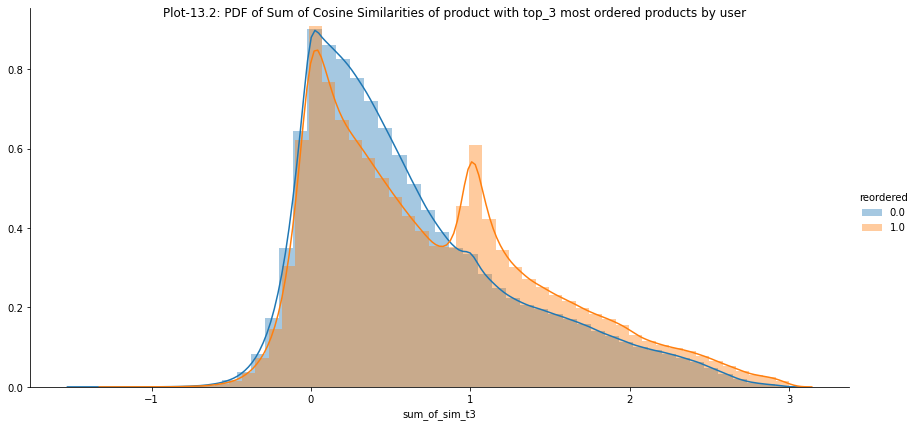

In [89]:
sns.FacetGrid(train_top_3_sim_products,hue='reordered',height=6,aspect=2).map(sns.distplot,'sum_of_sim_t3').add_legend().fig.suptitle('Plot-13.2: PDF of Sum of Cosine Similarities of product with top_3 most ordered products by user')

In [92]:
train_top_3_sim_products['prod_of_sim_t3']=train_top_3_sim_products.top_1_sim*train_top_3_sim_products.top_2_sim*train_top_3_sim_products.top_3_sim
train_top_3_sim_products.head()
# Took the product of top-3 similarities

,user_id,product_id,reordered,order_id,top_1_sim,top_2_sim,top_3_sim,max_sim_t3,sum_of_sim_t3,prod_of_sim_t3
0,1,196,1.0,1187899.0,1.000000,0.934235,0.905963,1.000000,2.840198,0.846383
1,1,12427,0.0,1187899.0,0.934235,1.000000,0.985929,1.000000,2.920164,0.921089
2,1,14084,0.0,1187899.0,0.089207,0.106976,0.122681,0.122681,0.318864,0.001171
3,1,26088,1.0,1187899.0,0.607246,0.798108,0.845998,0.845998,2.251352,0.410011
4,1,26405,1.0,1187899.0,0.534592,0.745773,0.790627,0.790627,2.070992,0.315211


Text(0.5, 0.98, 'Plot-13.3: PDF of Product of Cosine Similarities of product with top_3 most ordered products by user')

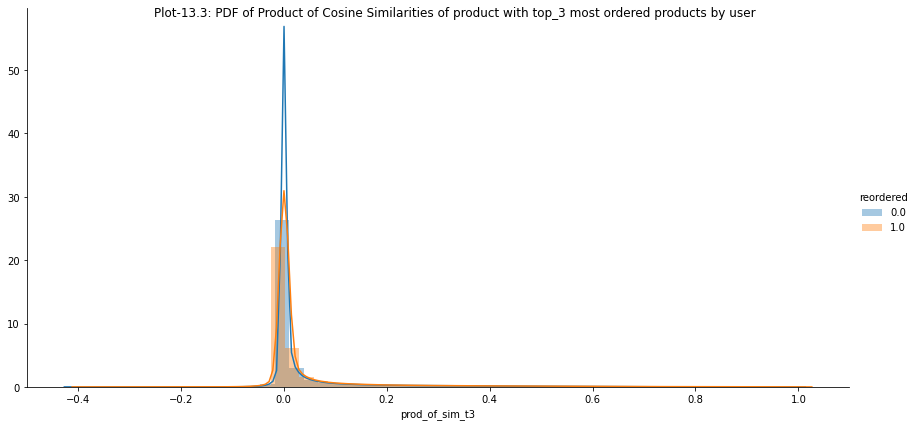

In [93]:
sns.FacetGrid(train_top_3_sim_products,hue='reordered',height=6,aspect=2).map(sns.distplot,'prod_of_sim_t3').add_legend().fig.suptitle('Plot-13.3: PDF of Product of Cosine Similarities of product with top_3 most ordered products by user')

### Plots- 13.1,13.2,13.3:
* *Plot 13.1 is PDF of maximum of Cosine Similarities between product a product and top-3 most ordered products of an user. We can observe that when max(Cosine Simialrities)=1 i.e., the product is among top-3 most ordered products by an user then it is more likely to be ordered. We can observe dominance of '1' in plot 13.1*


* *Plot 13.2 is PDF of sum of Cosine Similarities between product a product and top-3 most ordered products of an user. We can observe peak of '1' when the sum(Cosine Similiraties) is 1 and reordering dominated as the value increases. We can say that if the product is more similar(+ve and significant value) then the events of reordering can be more.*


* *Plot 13.3 is PDF of product of Cosine Similarities between product a product and top-3 most ordered products of an user. We can observe that peaks are centered at 0 as we are taking product. Significant classification is not observed but it may work well in combination with other features.*

### Storing in Database

In [94]:
user_prod_sim_with_top_3.head()

,user_id,product_id,top_1_sim,top_2_sim,top_3_sim
0,1,196,1.000000,0.934235,0.905963
1,1,12427,0.934235,1.000000,0.985929
2,1,14084,0.089207,0.106976,0.122681
3,1,26088,0.607246,0.798108,0.845998
4,1,26405,0.534592,0.745773,0.790627


In [95]:
user_prod_CS_features_set_1=user_prod_sim_with_top_3
user_prod_CS_features_set_1['max_sim_top3']=[max(i) for i in user_prod_CS_features_set_1[['top_1_sim','top_2_sim','top_3_sim']].values]
user_prod_CS_features_set_1['sum_of_sim_top3']=user_prod_CS_features_set_1.top_1_sim+user_prod_CS_features_set_1.top_2_sim+user_prod_CS_features_set_1.top_3_sim
user_prod_CS_features_set_1['prod_of_sim_top3']=user_prod_CS_features_set_1.top_1_sim*user_prod_CS_features_set_1.top_2_sim*user_prod_CS_features_set_1.top_3_sim

In [96]:
user_prod_CS_features_set_1.head()

,user_id,product_id,top_1_sim,top_2_sim,top_3_sim,max_sim_top3,sum_of_sim_top3,prod_of_sim_top3
0,1,196,1.000000,0.934235,0.905963,1.000000,2.840198,0.846383
1,1,12427,0.934235,1.000000,0.985929,1.000000,2.920164,0.921089
2,1,14084,0.089207,0.106976,0.122681,0.122681,0.318864,0.001171
3,1,26088,0.607246,0.798108,0.845998,0.845998,2.251352,0.410011
4,1,26405,0.534592,0.745773,0.790627,0.790627,2.070992,0.315211


In [57]:
user_prod_CS_features_set_1=user_prod_CS_features_set_1[['user_id','product_id','max_sim_top3','sum_of_sim_top3','prod_of_sim_top3']]

In [59]:
user_prod_CS_features_set_1[user_prod_CS_features_set_1.isnull().any(axis=1)]

,user_id,product_id,max_sim_top3,sum_of_sim_top3,prod_of_sim_top3


In [60]:
c.execute('create table user_prod_CosSim_features_set_1(user_id int,product_id int,max_sim_top3 decimal,sum_of_sim_top3 decimal,prod_of_sim_top3 decimal)')
user_prod_CS_features_set_1.to_sql('user_prod_CosSim_features_set_1',conn,if_exists='replace', index = False)

## ***17. Total number of times a product is ordered, mean of day of week it is ordered, median of hours of day it is ordered.***

*We observed in EDA that purchases from some of the departments like Breakfast, Alcohol vary when analysed in combination of day of week ordered and hour of day ordered. And number of time a product is purchased captures whether it'a an essential product. In EDA we observed top-20 of these products.*

In [6]:
%%time
query='''select product_id,count(*) as num_of_times_ordered,avg(order_dow) as mean_dow from order_products__prior tab_1
join orders tab_2 on tab_1.order_id=tab_2.order_id
group by product_id
'''
product_count_dow_avg=pd.read_sql_query(query,conn)

CPU times: user 45.3 s, sys: 9.39 s, total: 54.7 s
Wall time: 56.5 s


In [7]:
product_count_dow_avg[product_count_dow_avg.isnull().any(axis=1)]

,product_id,num_of_times_ordered,mean_dow


In [8]:
print('Number of unique products: {}'.format(product_count_dow_avg.product_id.unique().shape[0]))

Number of unique products: 49677


In [11]:
product_count_dow_avg.head()

,product_id,num_of_times_ordered,mean_dow
0,1,1852,2.776458
1,2,90,2.922222
2,3,277,2.736462
3,4,329,2.683891
4,5,15,2.733333


In [15]:
def median_hour_of_day(series):
    #This function return median of hour of day.
    #I am going with this function as SQLite3 does not have built in median aggregation function.
    return np.median(series)

In [18]:
query='''select product_id,order_hour_of_day from order_products__prior tab_1
join (select order_id,order_hour_of_day from orders) tab_2 on tab_1.order_id=tab_2.order_id
'''
grouped_HOD=pd.read_sql_query(query,conn).groupby('product_id').agg({'order_hour_of_day':median_hour_of_day}).reset_index()
grouped_HOD=pd.DataFrame(grouped_HOD.values,columns=['product_id','median_hod'])

In [20]:
product_count_dow_mean_hod_median=pd.merge(product_count_dow_avg,grouped_HOD,on='product_id',how='left')

In [22]:
product_count_dow_mean_hod_median.head()

,product_id,num_of_times_ordered,mean_dow,median_hod
0,1,1852,2.776458,13.0
1,2,90,2.922222,13.0
2,3,277,2.736462,12.0
3,4,329,2.683891,14.0
4,5,15,2.733333,11.0


In [23]:
#Merging with train
train_product_features=pd.merge(train_set,product_count_dow_mean_hod_median,on='product_id',how='left')

In [24]:
train_product_features[train_product_features.isnull().any(axis=1)]

,user_id,product_id,reordered,order_id,num_of_times_ordered,mean_dow,median_hod


In [25]:
train_product_features.head()

,user_id,product_id,reordered,order_id,num_of_times_ordered,mean_dow,median_hod
0,1,196,1.0,1187899.0,35791,2.898550,12.0
1,1,12427,0.0,1187899.0,6476,2.670784,12.0
2,1,14084,0.0,1187899.0,15935,2.697082,13.0
3,1,26088,1.0,1187899.0,2523,2.931431,13.0
4,1,26405,1.0,1187899.0,1214,2.765239,12.0


Text(0.5, 0.98, 'Plot-14.1: PDF of total number of times a product is ordered')

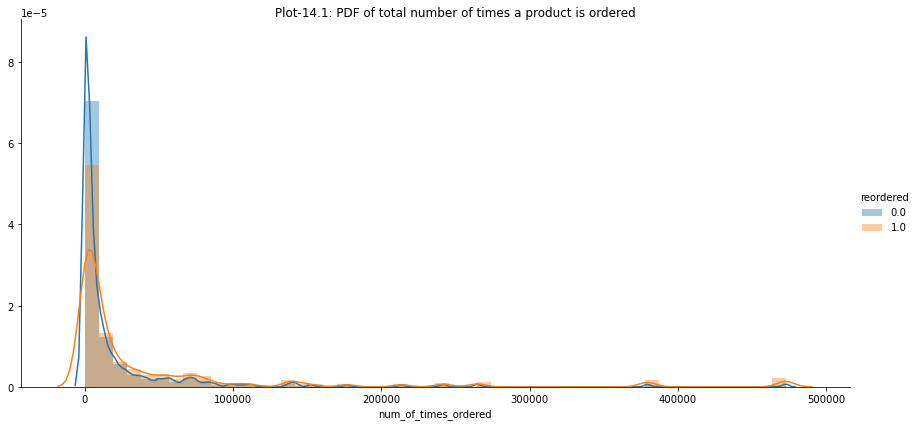

In [26]:
sns.FacetGrid(train_product_features,hue='reordered',height=6,aspect=2).map(sns.distplot,'num_of_times_ordered').add_legend().fig.suptitle('Plot-14.1: PDF of total number of times a product is ordered')

Text(0.5, 0.98, 'Plot-14.2: PDF of mean of days of week a product is ordered')

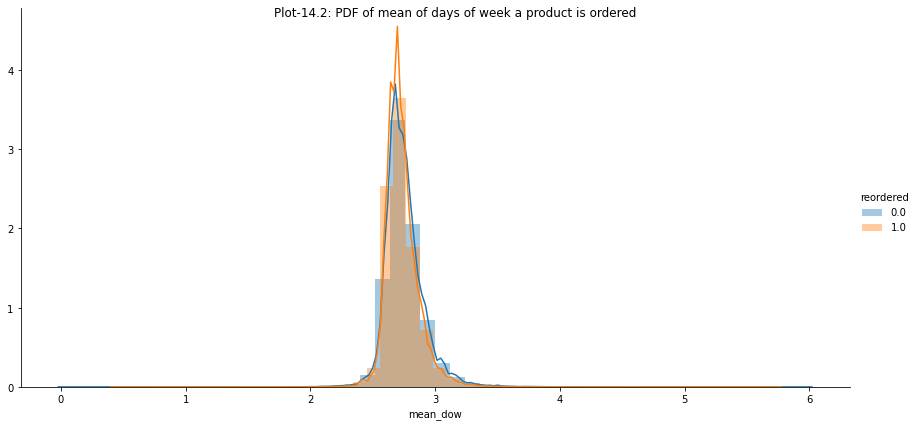

In [27]:
sns.FacetGrid(train_product_features,hue='reordered',height=6,aspect=2).map(sns.distplot,'mean_dow').add_legend().fig.suptitle('Plot-14.2: PDF of mean of days of week a product is ordered')

Text(0.5, 0.98, 'Plot-14.3: PDF of median of hours of day a product is ordered')

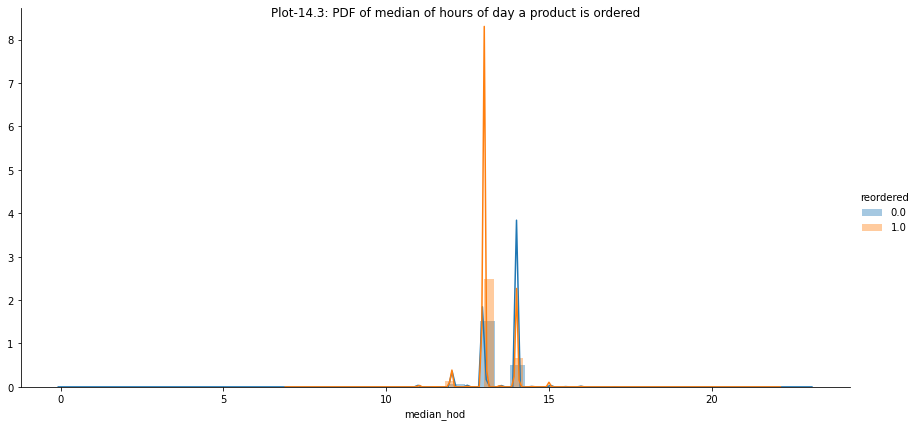

In [28]:
sns.FacetGrid(train_product_features,hue='reordered',height=6,aspect=2).map(sns.distplot,'median_hod').add_legend().fig.suptitle('Plot-14.3: PDF of median of hours of day a product is ordered')

Text(0.5, 0.98, 'Plot-14.4: PDF of median of hours of day a product is ordered where 12<median<15')

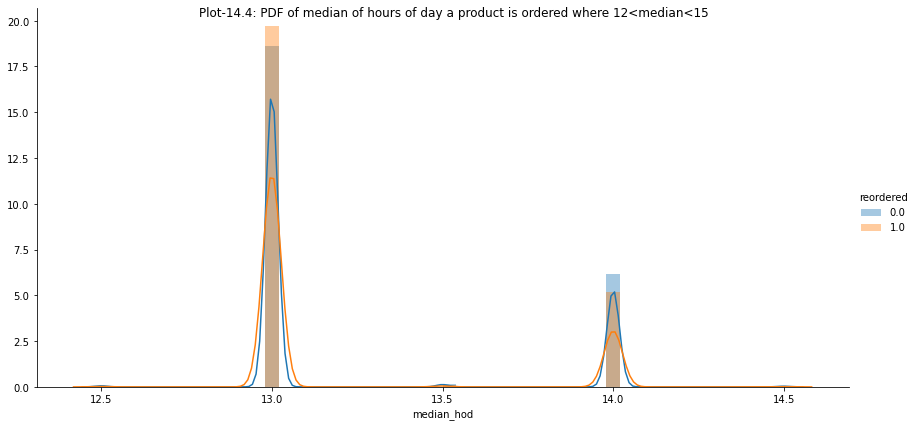

In [29]:
sns.FacetGrid(train_product_features[(train_product_features.median_hod>12)&(train_product_features.median_hod<15)],hue='reordered',height=6,aspect=2).map(sns.distplot,'median_hod').add_legend().fig.suptitle('Plot-14.4: PDF of median of hours of day a product is ordered where 12<median<15')

### Plots-14.1 to 14.4:
* *These we PDF of features related solely to product. None of them could classify the class label but thay might work in relation with any other.*

* *Plot 14.3-median of hours of day ordered is misleading. We can observe high domimance of required class label but when went deep and looked into that particular region in 14.4 it is actually not classifying.*

## ***18. Average number times a product is ordered***

### Average=number of times product is ordered/total number of unique users ordered it

*When a product is purchased by more number of times and it is purchased by more number of unique users then that product is much essential for everyone. For example product A is purchased 10000 times by 10 users and product B is purchased 10000 times by 100 users. Here product purchased count is same but number of users ordered differentiate them. Product A may be specific to a category like pets. People only with pets order them and all do ont have pets. But product B might be daily essential everyone needs.*

In [40]:
query='''select product_id,(count(*)*1.0/count(distinct(user_id))*1.0) as avg_num_of_times_prod_ordered from prior_user_product_combo
group by product_id
'''
avg_num_of_times_prod_ordered=pd.read_sql_query(query,conn)

In [41]:
avg_num_of_times_prod_ordered.head()

,product_id,avg_num_of_times_prod_ordered
0,1,2.586592
1,2,1.153846
2,3,3.743243
3,4,1.807692
4,5,2.500000


In [42]:
#Merging with train
train_avg_times_prod=pd.merge(train_set,avg_num_of_times_prod_ordered,on='product_id',how='left')

In [43]:
train_avg_times_prod[train_avg_times_prod.isnull().any(axis=1)]

,user_id,product_id,reordered,order_id,avg_num_of_times_prod_ordered


In [44]:
train_avg_times_prod.head()

,user_id,product_id,reordered,order_id,avg_num_of_times_prod_ordered
0,1,196,1.0,1187899.0,4.473875
1,1,12427,0.0,1187899.0,3.857058
2,1,14084,0.0,1187899.0,5.290505
3,1,26088,1.0,1187899.0,2.169390
4,1,26405,1.0,1187899.0,1.790560


Text(0.5, 0.98, 'Plot-15: PDF of Average number of time a product is ordered')

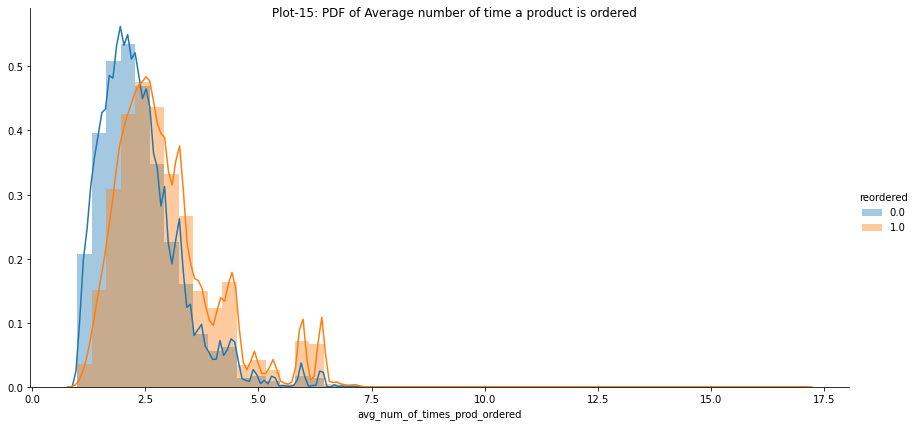

In [45]:
sns.FacetGrid(train_avg_times_prod,hue='reordered',height=6,aspect=2).map(sns.distplot,'avg_num_of_times_prod_ordered').add_legend().fig.suptitle('Plot-15: PDF of Average number of time a product is ordered')

### Plot-15:
* *This plot is PDF of average number or times a product is ordered. Here, average is ratio of total number of times a product is ordered and number of unique users ordered it.*
* *We can observe that as average increases reordering increased. Which does mean that those products which are ordered by most number of users and less number of times were not highly reordered. For example if a product is ordered 1000 times by 700 users it is not highly reordered. Which does mean the review of product is bad and user did not reorder the product or user posted a negative review so that other users did not buy it? May be.*

### Storing product related features in Database

In [46]:
product_featues_set_1=pd.merge(product_count_dow_mean_hod_median,avg_num_of_times_prod_ordered,on='product_id',how='outer')

In [47]:
product_featues_set_1[product_featues_set_1.isnull().any(axis=1)]

,product_id,num_of_times_ordered,mean_dow,median_hod,avg_num_of_times_prod_ordered


In [48]:
product_featues_set_1.head()

,product_id,num_of_times_ordered,mean_dow,median_hod,avg_num_of_times_prod_ordered
0,1,1852,2.776458,13.0,2.586592
1,2,90,2.922222,13.0,1.153846
2,3,277,2.736462,12.0,3.743243
3,4,329,2.683891,14.0,1.807692
4,5,15,2.733333,11.0,2.500000


In [49]:
c.execute('create table product_featues_set_1(product_id int, num_of_times_ordered int, mean_dow decimal, median_hod decimal, avg_num_of_times_prod_ordered decimal)')
product_featues_set_1.to_sql('product_featues_set_1',conn,if_exists='replace', index = False)

## ***19. Days since ordered last time test***

In [4]:
%%time
query='''select order_id,user_id,product_id from prior_user_product_combo
union all
select order_id,user_id,product_id from test_data
'''
# This is for temporary purpose to fetch previous gap, attaching test with prior to see on what day of user is he/she ordering again.
data_for_joining_with_orders_refined_test=pd.read_sql_query(query,conn)

CPU times: user 58.1 s, sys: 3.65 s, total: 1min 1s
Wall time: 1min 1s


In [8]:
orders_refined=pd.read_sql_query("select * from orders_refined where eval_set!='train'",conn)

In [9]:
joined_for_previous_gap_test=pd.merge(orders_refined,data_for_joining_with_orders_refined_test,on=['order_id','user_id'],how='outer')

In [10]:
joined_for_previous_gap_test[joined_for_previous_gap_test.isnull().any(axis=1)]

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,order_day_of_user,product_id


In [12]:
joined_for_previous_gap_test[joined_for_previous_gap_test.user_id==4]

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,order_day_of_user,product_id
375,3343014,4,prior,1,6,11,1.0,2707
376,3343014,4,prior,1,6,11,1.0,7350
377,3343014,4,prior,1,6,11,1.0,35469
378,3343014,4,prior,1,6,11,1.0,36606
379,2030307,4,prior,2,4,11,20.0,7160
380,2030307,4,prior,2,4,11,20.0,42329
381,691089,4,prior,3,4,15,41.0,1200
382,691089,4,prior,3,4,15,41.0,11865
383,691089,4,prior,3,4,15,41.0,17769
384,691089,4,prior,3,4,15,41.0,19057


In [14]:
def prev_gap(series): 
    # This function return how many days back an user ordered paticular product last time.
    try:
        return np.diff(series)[-1]
    except IndexError:
        return -1
        # IndexError arises for train data(eval_set='train') as I did not included it.
        # Returning -1 for temporary purpose.

In [15]:
%%time
temp=joined_for_previous_gap_test[['user_id','product_id','order_day_of_user']].groupby(['user_id','product_id']).agg({'order_day_of_user':prev_gap}).reset_index()
previous_gap_test=pd.DataFrame(temp.values,columns=['user_id','product_id','days_since_last_ordered'])
previous_gap_test.head()

CPU times: user 6min 4s, sys: 1.05 s, total: 6min 5s
Wall time: 6min 5s


,user_id,product_id,days_since_last_ordered
0,1.0,196.0,30.0
1,1.0,10258.0,30.0
2,1.0,10326.0,-1.0
3,1.0,12427.0,30.0
4,1.0,13032.0,44.0


In [16]:
previous_gap_test[previous_gap_test.isnull().any(axis=1)]

,user_id,product_id,days_since_last_ordered


In [17]:
c.execute('create table days_since_last_ordered_test(user_id int, product_id int, days_since_last_ordered int)')
previous_gap_test.to_sql('days_since_last_ordered_test', conn, if_exists='replace', index = False)

# **Baseline models**

In [5]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

*Here I analyzed some rule based non-ML baseline models using features that showed considerable classification in EDA.*

### **Performance metric**:
   *The performance metric I am considering here is Recall of 1='will reorder'.*

In [6]:
train_only_1=train_set[train_set.reordered==1]
train_only_1.head()

,user_id,product_id,reordered,order_id
0,1,196,1.0,1187899.0
3,1,26088,1.0,1187899.0
4,1,26405,1.0,1187899.0
5,1,10258,1.0,1187899.0
6,1,13032,1.0,1187899.0


*Recall of '1=will reorder' is nothing but accuracy of that particular label. So I considered only '1=will reorder' from train, predict label using rules and check accuracy of 1(recall of 1)*

In [7]:
%%time
user_features_set_1=pd.read_sql_query('select * from user_features_set_1',conn)
days_since_last_ordered_train=pd.read_sql_query('select * from days_since_last_ordered_train',conn)
user_product_interraction_L5_set_1=pd.read_sql_query('select * from user_product_interraction_L5_set_1',conn)
user_product_interraction_set_1=pd.read_sql_query('select * from user_product_interraction_set_1',conn)
user_prod_CosSim_features_set_1=pd.read_sql_query('select * from user_prod_CosSim_features_set_1',conn)
product_featues_set_1=pd.read_sql_query('select * from product_featues_set_1',conn)

CPU times: user 2min 48s, sys: 7.69 s, total: 2min 55s
Wall time: 3min 19s


## **Baseline-1**
**Features used**:*How many times user ordered product in recent 5 orders(u_p_count_L5), Maximum gap of user ordered particular product in recent 5 orders(max_gap_L5)*

**Rule**: *Label=1 if u_p_count_L5>=3 and max_gap_L5>5*

In [8]:
train_1_u_p_count_gap=pd.merge(train_only_1,user_product_interraction_L5_set_1[['user_id','product_id','max_gap_L5','u_p_count_L5']],on=['user_id','product_id'],how='left')
train_1_u_p_count_gap.head()

,user_id,product_id,reordered,order_id,max_gap_L5,u_p_count_L5
0,1,196,1.0,1187899.0,30.0,5.0
1,1,26088,1.0,1187899.0,NaN,NaN
2,1,26405,1.0,1187899.0,NaN,NaN
3,1,10258,1.0,1187899.0,30.0,5.0
4,1,13032,1.0,1187899.0,44.0,2.0


In [9]:
train_1_u_p_count_gap.fillna({'u_p_count_L5':0,'max_gap_L5':-1},inplace=True)

In [10]:
y_true=train_1_u_p_count_gap.reordered.values
y_pred=[]
for i in tqdm(train_1_u_p_count_gap[['max_gap_L5','u_p_count_L5']].values):
    if i[0]>5 and i[1]>=3:
        y_pred.append(1)
    else:
        y_pred.append(0)
print("Recall on '1=will reorder': {}".format(accuracy_score(y_true,y_pred)))

100%|██████████| 828824/828824 [00:02<00:00, 390929.90it/s]


Recall on '1=will reorder': 0.28757854502282754


## **Baseline-2**
**Features used**:*How many times user ordered product in recent 5 orders(u_p_count_L5), Maximum gap of user ordered particular product in recent 5 orders(max_gap_L5), days_since_last_ordered*

**Rule**: *Label=1 if u_p_count_L5>=3, max_gap_L5>5 and days_since_last_ordered<30*

In [11]:
train_1_u_p_count_prev_gap=pd.merge(train_only_1,user_product_interraction_L5_set_1[['user_id','product_id','max_gap_L5','u_p_count_L5']],on=['user_id','product_id'],how='left')
train_1_u_p_count_prev_gap=pd.merge(train_1_u_p_count_prev_gap,days_since_last_ordered_train,on=['user_id','product_id'],how='left')
train_1_u_p_count_prev_gap.head()

,user_id,product_id,reordered,order_id,max_gap_L5,u_p_count_L5,days_since_last_ordered
0,1,196,1.0,1187899.0,30.0,5.0,14.0
1,1,26088,1.0,1187899.0,NaN,NaN,175.0
2,1,26405,1.0,1187899.0,NaN,NaN,125.0
3,1,10258,1.0,1187899.0,30.0,5.0,14.0
4,1,13032,1.0,1187899.0,44.0,2.0,14.0


In [12]:
train_1_u_p_count_prev_gap.fillna({'u_p_count_L5':0,'max_gap_L5':-1},inplace=True)

In [13]:
y_true=train_1_u_p_count_prev_gap.reordered.values
y_pred=[]
for i in tqdm(train_1_u_p_count_prev_gap[['max_gap_L5','u_p_count_L5','days_since_last_ordered']].values):
    if i[0]>5 and i[1]>=3 and i[2]<30:
        y_pred.append(1)
    else:
        y_pred.append(0)
print("Recall on '1=will reorder': {}".format(accuracy_score(y_true,y_pred)))

100%|██████████| 828824/828824 [00:03<00:00, 269534.79it/s]


Recall on '1=will reorder': 0.20770996013628948


## **Baseline-3**
**Features used**:*Order ratio of product after user first encounters it(u_p_ratio_aft_first), total number of times user ordered a product(u_p_count) *

**Rule**: *Label=1 if u_p_count>=5 and u_p_ratio_aft_first>0.5*

In [14]:
train_1_u_p_count_aft_first=pd.merge(train_only_1,user_product_interraction_set_1[['user_id','product_id','u_p_count','u_p_ratio_aft_first']],on=['user_id','product_id'],how='left')
train_1_u_p_count_aft_first.head()

,user_id,product_id,reordered,order_id,u_p_count,u_p_ratio_aft_first
0,1,196,1.0,1187899.0,10,1.000000
1,1,26088,1.0,1187899.0,2,0.200000
2,1,26405,1.0,1187899.0,2,0.200000
3,1,10258,1.0,1187899.0,9,1.000000
4,1,13032,1.0,1187899.0,3,0.333333


In [15]:
y_true=train_1_u_p_count_aft_first.reordered.values
y_pred=[]
for i in tqdm(train_1_u_p_count_aft_first[['u_p_count','u_p_ratio_aft_first']].values):
    if i[0]>=5 and i[1]>0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)
print("Recall on '1=will reorder': {}".format(accuracy_score(y_true,y_pred)))

100%|██████████| 828824/828824 [00:02<00:00, 343790.51it/s]


Recall on '1=will reorder': 0.18412352924143124


## **Baseline-4**
**Features used**:*Order ratio of product after user first encounters it(u_p_ratio_aft_first), total number of times user ordered a product(u_p_count), mean of gaps between user ordered particular product(mean_gap)*

**Rule**: *Label=1 if u_p_count>=5, u_p_ratio_aft_first>0.5 and 5<mean_gap<30*

In [16]:
train_1_u_p_count_aft_first_mean_gap=pd.merge(train_only_1,user_product_interraction_set_1[['user_id','product_id','u_p_count','u_p_ratio_aft_first','mean_gap']],on=['user_id','product_id'],how='left')
train_1_u_p_count_aft_first_mean_gap.head()

,user_id,product_id,reordered,order_id,u_p_count,u_p_ratio_aft_first,mean_gap
0,1,196,1.0,1187899.0,10,1.000000,19.555556
1,1,26088,1.0,1187899.0,2,0.200000,15.000000
2,1,26405,1.0,1187899.0,2,0.200000,65.000000
3,1,10258,1.0,1187899.0,9,1.000000,20.125000
4,1,13032,1.0,1187899.0,3,0.333333,80.500000


In [17]:
y_true=train_1_u_p_count_aft_first_mean_gap.reordered.values
y_pred=[]
for i in tqdm(train_1_u_p_count_aft_first_mean_gap[['u_p_count','u_p_ratio_aft_first','mean_gap']].values):
    if i[0]>=5 and i[1]>0.5 and i[2]>5 and i[2]<30:
        y_pred.append(1)
    else:
        y_pred.append(0)
print("Recall on '1=will reorder': {}".format(accuracy_score(y_true,y_pred)))

100%|██████████| 828824/828824 [00:01<00:00, 424710.69it/s]


Recall on '1=will reorder': 0.16608351109523856


## **Baseline-5**
**Features used**:*Maximum Cosine Similarity of product with top_3 most ordered products by user(max_sim_t3), Sum of Cosine Similarities of product with top_3 most ordered products by user(sum_of_sim_t3)*

**Rule**: *Label=1 if max_sim_top3=1, sum_of_sim_top3>0.8*

In [18]:
train_1_u_p_max_sum_CS=pd.merge(train_only_1,user_prod_CosSim_features_set_1[['user_id','product_id','max_sim_top3','sum_of_sim_top3']],on=['user_id','product_id'],how='left')
train_1_u_p_max_sum_CS.head()

,user_id,product_id,reordered,order_id,max_sim_top3,sum_of_sim_top3
0,1,196,1.0,1187899.0,1.000000,2.840198
1,1,26088,1.0,1187899.0,0.845998,2.251352
2,1,26405,1.0,1187899.0,0.790627,2.070992
3,1,10258,1.0,1187899.0,1.000000,2.891892
4,1,13032,1.0,1187899.0,0.951201,2.754353


In [19]:
y_true=train_1_u_p_max_sum_CS.reordered.values
y_pred=[]
for i in tqdm(train_1_u_p_max_sum_CS[['max_sim_top3','sum_of_sim_top3']].values):
    if i[0]>=1 and i[1]>0.8:
        y_pred.append(1)
    else:
        y_pred.append(0)
print("Recall on '1=will reorder': {}".format(accuracy_score(y_true,y_pred)))

100%|██████████| 828824/828824 [00:01<00:00, 593838.86it/s]


Recall on '1=will reorder': 0.12180993793616016


## **Baseline models summary**:
* *Combination of 'How many times user ordered product in last 5 orders?' and 'Maximum gap between user ordering product in last 5 orders' shown best recall among the baseline models.*
* *Following that the combo of above two and days since user last ordered that product gave the next best recall. This is only concerned with linearity as I went with rule based baseline models. Non-linear models may learn more from this combination as we have observed that in EDA.*
* *Other baseline models that were tried on few User product interraction features on all prior orders and baseline model using  features of Cosine Similarity with top 3 most ordered products did not work well and it's evident with EDA that they did not show clear linear seperation. Machine Learning models especially non-linear may learn more from this.*